# Cancellation Prediction for Booking Using Machine Learning Models
Guy Dahan, Tamar Shnirer
# TOC

* [Introduction](#Introduction)
    * [Summary](#Summary)
1. [Part 1: Exploration, Basic Hypothesis](#part1)
1. [Part 2: Preprocessing](#part2)
1. [Part 3: Modeling](#part3)
1. [Part 4: Evaluating the Models](#part4)
1. [Part 5: Predictions for Test Data](#part5)

# Introduction <a class="anchor" id="Introduction"></a>


## Summary <a class="anchor" id="Summary"></a>
In this Machine learning project our goal is to showcase the use of different data analyzing and machine learning tools in order to create a trained model
to predict booking cancellation from a given specific data.<br>

Please visit our repo for this project: <br>

https://github.com/Guydada/Machine-Learning-Project---Guy-and-Tamar


## Import Libraries

In [1]:
import numpy as np
from numpy import interp
import pandas as pd
from scipy import stats
from IPython.display import display, HTML, Image

from modules.project_supp import convert_column_to_num_month, month_num_season, month_int_to_str

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import figure
import missingno as msno
import plotly.express as px
import seaborn as sns

from pipelinehelper import PipelineHelper

import xgboost as xgb
import category_encoders as ce
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the main data and the train data

df, y = map(pd.read_csv, (['Data/feature_data.csv', 'Data/label_data.csv']))

# Temporarily load cancellation column to the main data for exploration
df['cancelation'] = y['cancelation']

## The Plan

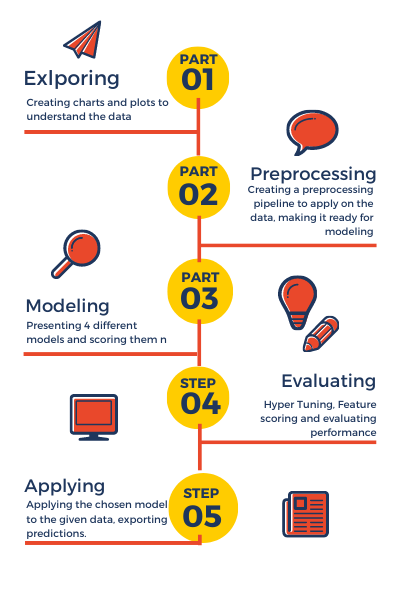

In [3]:
display(Image('Yellow Design Process Blog Graphic(1).png', width=400, height=600))

## First Look on the Data
Currently, displayed are the first 10 rows of the data

In [4]:
df.head(10)

,Unnamed: 0,time_until_order,order_year,order_month,order_week,order_day_of_month,adults,children,babies,country,...,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_12,anon_feat_13,cancelation
0,51014,309.0,2016,May,week_20,13,2,0.0,0,PRT,...,0.0,215.0,0.0,0,0.0,0.250606,17.588299,True,1.0,True
1,28536,3.0,2016,October,week_41,2,2,0.0,0,ESP,...,3.0,0.0,1.0,1,1.0,0.444719,2.343371,True,NaN,False
2,21745,NaN,2017,March,week_12,19,1,0.0,0,DEU,...,4.0,0.0,0.0,0,1.0,0.598733,2.498820,True,NaN,False
3,17502,153.0,2015,September,week_40,29,2,0.0,0,GBR,...,3.0,0.0,0.0,0,1.0,0.335675,12.411559,True,NaN,False
4,83295,33.0,2016,January,week_5,25,2,0.0,0,BRA,...,0.0,15.0,0.0,0,0.0,0.492874,5.743378,True,NaN,False
5,67872,50.0,2017,May,week_19,8,2,2.0,0,AGO,...,5.0,0.0,0.0,0,0.0,0.297551,7.234509,True,NaN,True
6,21763,NaN,2016,March,week_11,9,1,0.0,0,PRT,...,0.0,0.0,0.0,0,1.0,0.514393,2.490639,True,NaN,False
7,16156,72.0,2015,NaN,week_33,9,2,0.0,0,NaN,...,0.0,0.0,0.0,2,1.0,0.372214,8.449535,True,NaN,False
8,100645,180.0,2016,October,week_44,28,2,0.0,0,NaN,...,0.0,0.0,0.0,2,0.0,0.427402,13.497397,True,NaN,False
9,95004,280.0,2016,August,week_33,12,2,2.0,0,GBR,...,NaN,0.0,1.0,2,0.0,0.182388,16.723083,False,0.0,False


## Dataframe Info
As seen below this data has 33 features currently of different types.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89542 entries, 0 to 89541
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           89542 non-null  int64  
 1   time_until_order     76861 non-null  float64
 2   order_year           89542 non-null  int64  
 3   order_month          86108 non-null  object 
 4   order_week           89542 non-null  object 
 5   order_day_of_month   89542 non-null  int64  
 6   adults               89542 non-null  int64  
 7   children             89538 non-null  float64
 8   babies               89542 non-null  int64  
 9   country              85201 non-null  object 
 10  order_type           89542 non-null  object 
 11  acquisition_channel  89542 non-null  object 
 12  prev_canceled        89542 non-null  int64  
 13  prev_not_canceled    89542 non-null  int64  
 14  changes              86065 non-null  float64
 15  deposit_type         80536 non-null 

In [6]:
df.describe().style.format('{:.2f}')

,Unnamed: 0,time_until_order,order_year,order_day_of_month,adults,children,babies,prev_canceled,prev_not_canceled,changes,agent,company,adr,anon_feat_0,anon_feat_1,anon_feat_2,anon_feat_3,anon_feat_4,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_13
count,89542.00,76861.00,89542.00,89542.00,89542.00,89538.00,89542.00,89542.00,89542.00,86065.00,77346.00,5062.00,86559.00,86161.00,89542.00,89542.00,89542.00,89542.00,85510.00,85309.00,85294.00,89542.00,85811.00,86810.00,84585.00,5776.00
mean,59716.76,103.67,2016.16,15.83,1.86,0.10,0.01,0.09,0.14,0.22,86.73,189.10,2218.10,0.93,2.50,0.56,0.03,0.99,1.33,2.34,0.06,0.57,0.34,0.43,8.85,0.37
std,34495.24,106.94,0.71,8.78,0.57,0.40,0.10,0.85,1.50,0.66,110.81,130.80,4421.17,1.00,1.92,1.07,0.18,1.70,1.88,17.52,0.24,0.79,0.47,0.13,5.24,0.48
min,0.00,0.00,2015.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.04,0.00
25%,29838.25,18.00,2016.00,8.00,2.00,0.00,0.00,0.00,0.00,0.00,9.00,67.00,84.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,4.45,0.00
50%,59743.50,69.00,2016.00,16.00,2.00,0.00,0.00,0.00,0.00,0.00,14.00,179.00,149.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,8.42,0.00
75%,89610.50,159.00,2017.00,23.00,2.00,0.00,0.00,0.00,0.00,0.00,229.00,270.00,1241.00,2.00,3.00,0.00,0.00,3.00,3.00,0.00,0.00,1.00,1.00,0.51,12.71,1.00
max,119388.00,737.00,2017.00,31.00,55.00,10.00,10.00,26.00,72.00,21.00,535.00,543.00,42625.00,19.00,50.00,4.00,1.00,9.00,11.00,391.00,3.00,5.00,1.00,0.91,27.17,1.00


## Tidying the Data
In this section we won't begin "preprocessing", but
we will commit some minor changes in order to read the data properly.
### Changing Features to Numeric Value
In the beginning we would perform no changes to the data but tidying it

In [7]:
def numbers_to_str(df):
    # Weeks and months
    df["order_month"] = convert_column_to_num_month(df, "order_month")
    df['order_week'] = df['order_week'].str.strip("week_").astype(int)
    # Bol to int
    df['anon_feat_12'] = df['anon_feat_12'].astype(int)
    return df

In [8]:
# adding the supplied labels for visualising the data better

y['cancelation'] = y['cancelation'].astype(int)
df['cancelation'] = df['cancelation'].astype(int)
df = numbers_to_str(df)

# Part 1: Exploration, Basic Hypothesis <a class="anchor" id="part1"></a>

## Histograms

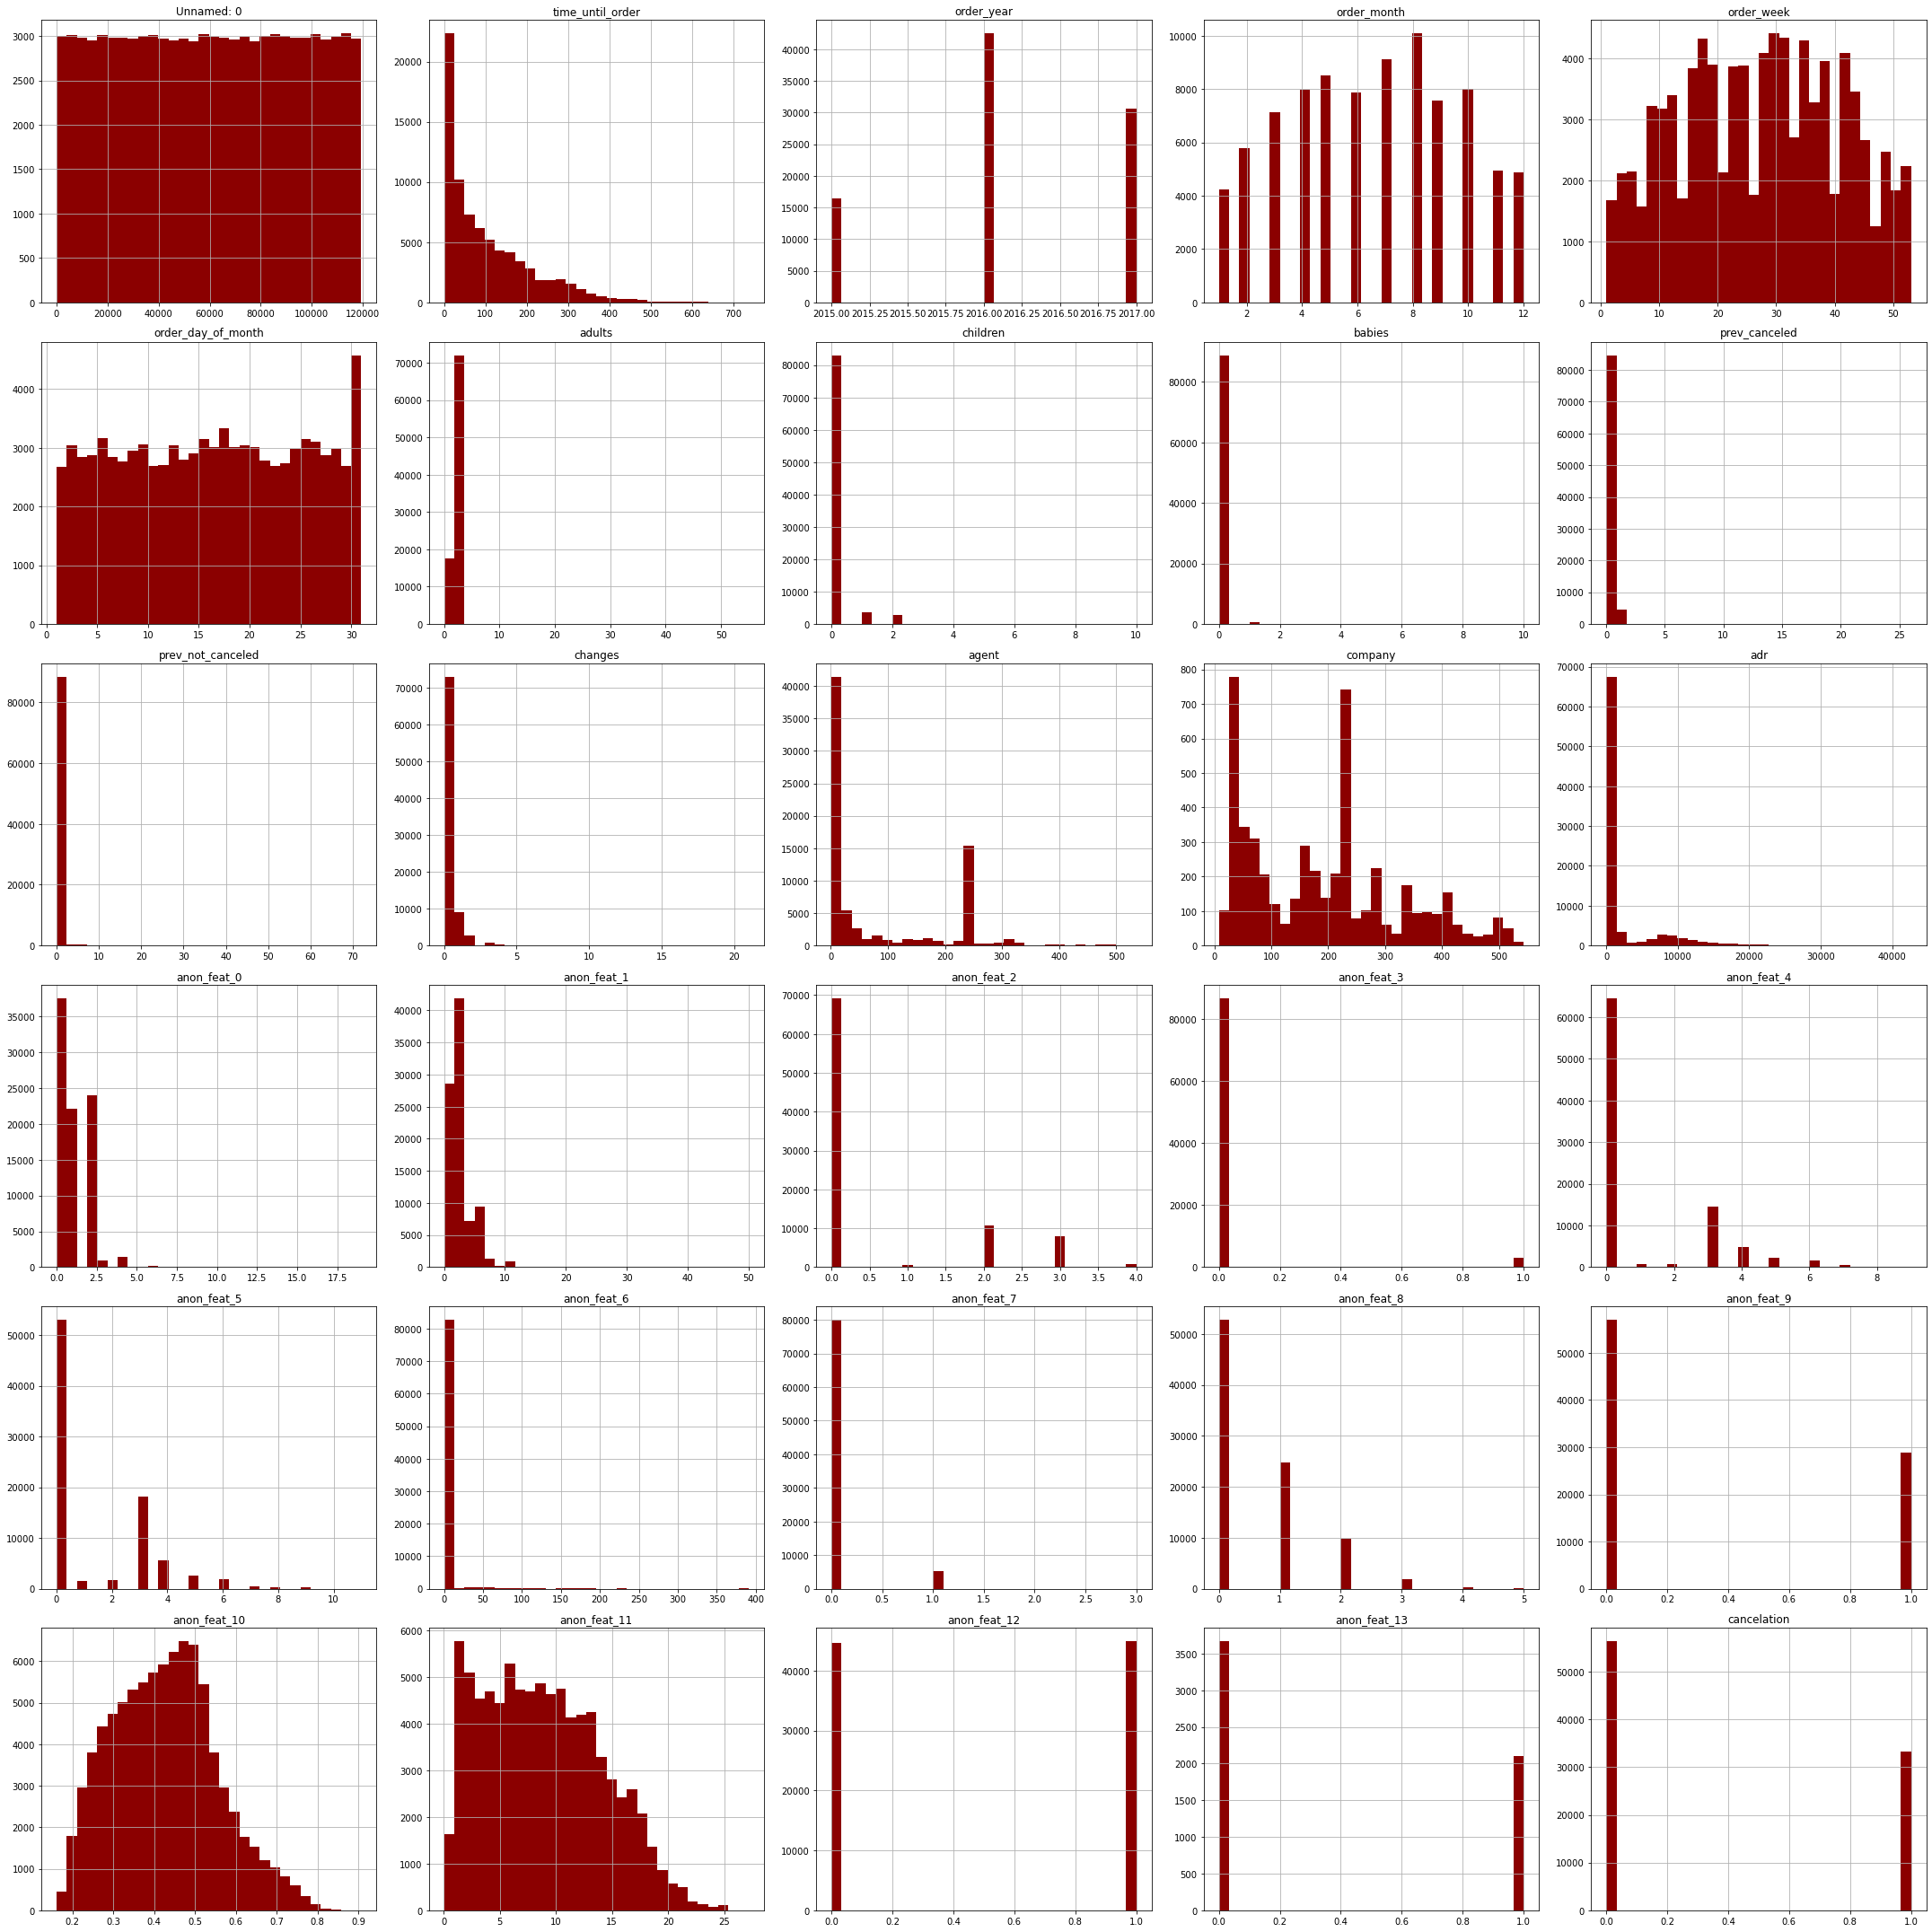

In [9]:
df.hist(figsize=(30,30), bins=30, color='darkred')
plt.tight_layout()
plt.show()

The histograms for the feature let us distinct between the different types of features in the data. We will now conitnue to explore those exact feature. 

## Creating New Features for Visualization 
We have decided that a few manipulations can be done on the features from the begining to make visualizing the data easier.
We think some features can be discarded  completely, and some new ones should be created.

Features to create:
* Season - by year's months.
* Country Cancel Ratio
* "Has kids" - boolean feature

After exploring and visualising the data we will discuss what features to drop.

This would be the season feature we chose to introduce, together with the "has_kids" boolean feature.

In [10]:
seasons = {1: "Spring", 2: "Summer", 3:"Autumn", 4: "Winter"}

In [11]:
def new_features(df):
    # Creating seasons
    df['season'] = df['order_month'].apply(month_num_season)
    # Creating "has_kids" feature
    df['has_kids'] = df['children'] > 0
    df['has_kids'] = df['has_kids'].astype(int)
    return df

In [12]:
# apply new feature to df

df = new_features(df)

## Correlation Matrix, Examining Correlations in the Data and Label Data
Now that we have created some new basic features, we would like to examine the existing correlations before the EDA

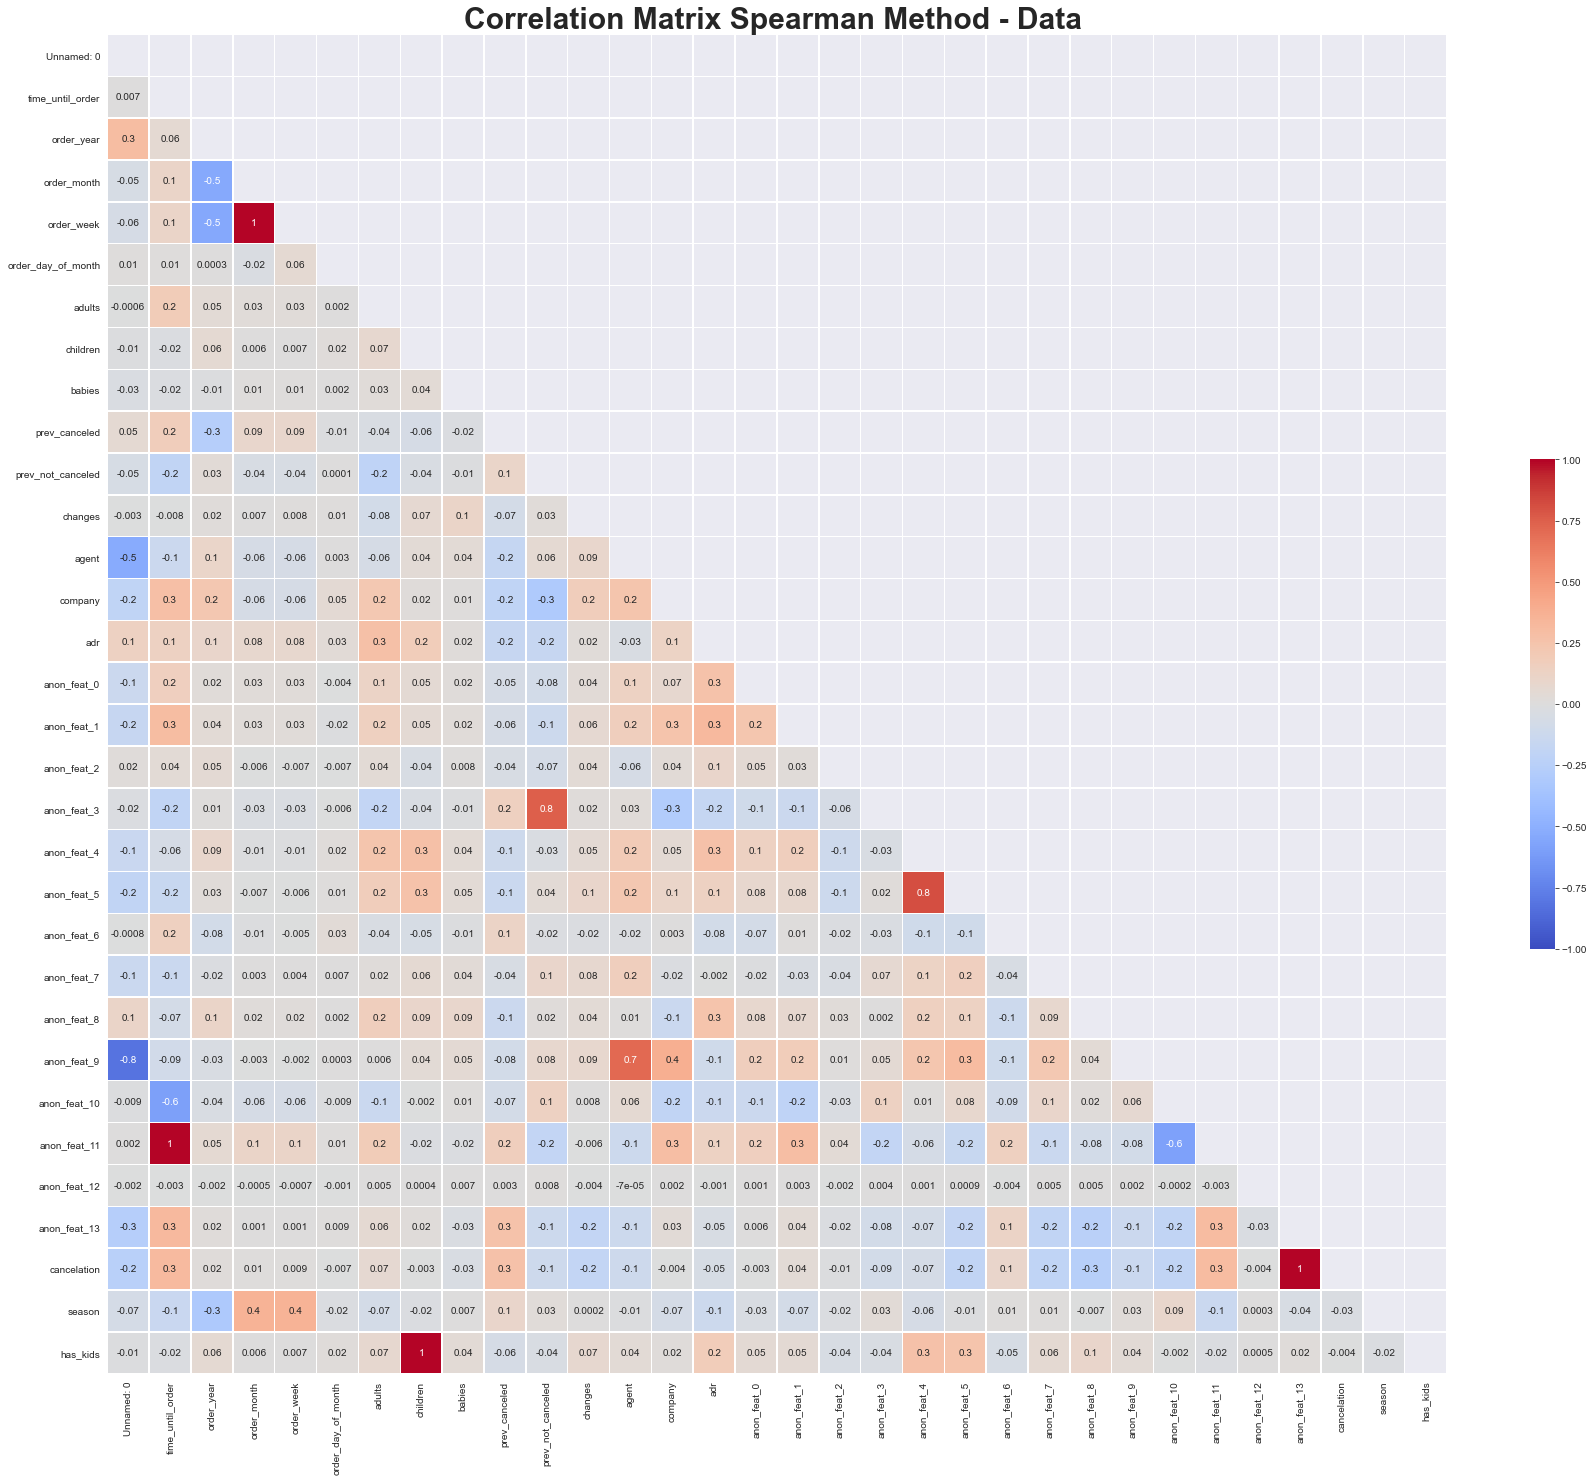

In [13]:
plt.figure(figsize=(30,30))
sns.set_style('darkgrid')
corr=df.corr(method='spearman')
mask_corr = np.triu(np.ones_like(corr, dtype=bool))
heat = sns.heatmap(corr, square=True,
            annot=True, fmt='.1g', linewidths=0.5,
            linecolor='white', cmap= 'coolwarm', mask=mask_corr,
            vmin=-1, vmax=1, cbar_kws={'shrink': 0.3},
            annot_kws={"fontsize":10},)
plt.title("Correlation Matrix Spearman Method - Data ",size=30, weight='bold')
plt.show()

### Analyzing the Correlation Matrix

Those are the top correlating values, above 55% of correlation.

In [14]:
corr = corr[corr>=0.55]
corr = corr.abs()
corr = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
corr

anon_feat_13       cancelation     1.000000
time_until_order   anon_feat_11    0.999476
children           has_kids        0.999310
order_month        order_week      0.995450
anon_feat_4        anon_feat_5     0.813804
prev_not_canceled  anon_feat_3     0.755504
agent              anon_feat_9     0.713712
dtype: float64

We have recognized a few suggested correlations:
* It is very clear that anon_feat_13 is actually the cancelling situation from the labels data, with a 100% correlation.
* anon feature 11 - time until order
* agent - anon feat 9
* anon feature 5 - anon feature 4
    
    
of course, we can discard order month and order week correlations, as well as "has_kids" and children.


## Label Data

In [15]:
cancel_corr = df.corr()["cancelation"]
cancel_corr.abs().sort_values(ascending=False)[1:]

anon_feat_13          1.000000
anon_feat_11          0.313919
time_until_order      0.294502
Unnamed: 0            0.242871
anon_feat_8           0.233985
anon_feat_10          0.204077
anon_feat_7           0.197533
anon_feat_5           0.176803
changes               0.144559
anon_feat_9           0.136527
prev_canceled         0.109633
anon_feat_3           0.085612
agent                 0.081911
adr                   0.070436
anon_feat_4           0.060772
prev_not_canceled     0.060068
anon_feat_6           0.058219
adults                0.058103
babies                0.032331
season                0.030098
anon_feat_1           0.026997
anon_feat_2           0.016972
order_year            0.014949
company               0.012482
order_month           0.012261
order_week            0.009628
order_day_of_month    0.006737
children              0.005691
has_kids              0.004485
anon_feat_12          0.004417
anon_feat_0           0.000038
Name: cancelation, dtype: float64

It is apparent as mentioned that anon_feat_13 needs to be removed. It is probably a feature that was assembled from training labels, therefore it has 100% correlation.

The most important features are:

* anon_feat_11
* time_until_order
* anon_feat_8

The Unnamed: 0 feature is a misleading correlation, this represents the costumer's idea, therefore we can assume this is a random correlation.

Further more, even though some features show low correlation, we will choose not to dismiss them for now. <br>
It is important to understand at this stage what is the distribution of cancelation in general and for specific features

## Visualisation of the Data

### Cancellation Count

<Figure size 720x720 with 0 Axes>

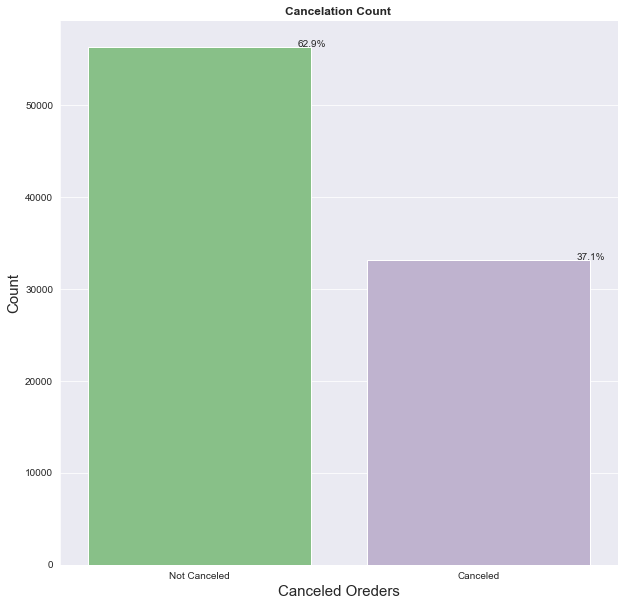

In [16]:
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
fig, bar = plt.subplots(figsize = (10,10))
bar = sns.countplot(x='cancelation', data= df, palette='Accent',
                    orient = 'v')
bar.set_xticklabels(['Not Canceled', 'Canceled'])
sns.despine()
total = float(len(y))

for p in bar.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x1 = p.get_x() + p.get_width()
    y1 = p.get_height()
    bar.annotate(percentage, (x1, y1),ha='center')
bar.set_title('Cancelation Count ', weight='bold')
bar.set_xlabel('Canceled Oreders', fontsize=15)
bar.set_ylabel('Count', fontsize=15)
plt.show()

### Seasons vs number of orders

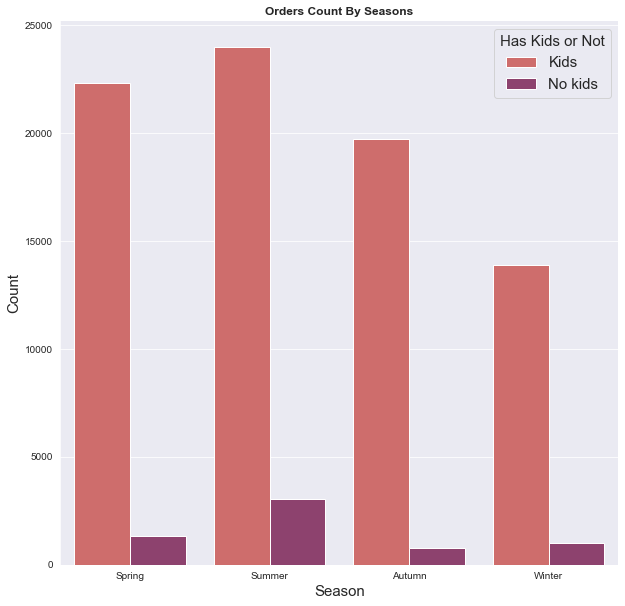

In [17]:
sns.set_style('darkgrid')
fig, bar = plt.subplots(figsize = (10,10))

bar = sns.countplot(x='season', hue='has_kids', data= df, palette='flare',
                    orient = 'v')
bar.set_xticklabels([sea for sea in seasons.values()])
sns.despine()
bar.legend(title='Has Kids or Not', labels=['Kids', 'No kids']
           ,loc='upper right',
           fontsize=15, title_fontsize=15)
bar.set_title('Orders Count By Seasons', weight='bold')
bar.set_xlabel('Season', fontsize=15)
bar.set_ylabel('Count', fontsize=15)
plt.show()

### Kids Number vs order month

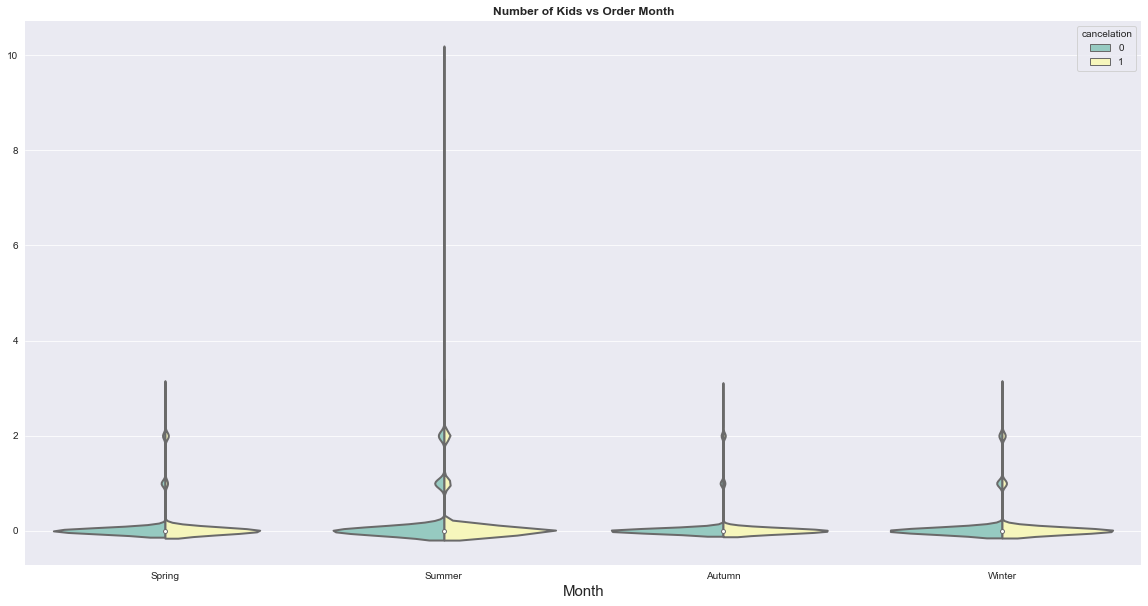

In [18]:
fig = plt.figure(figsize=(20,10))
vil = sns.violinplot(x='season', y ='children', hue='cancelation', data=df, palette="Set3", bw=.2,
               cut=2, linewidth=2, iner= 'box', split = True)
sns.despine(left=True)
plt.title('Number of Kids vs Order Month', weight='bold')
vil.set_xticklabels([sea for sea in seasons.values()])
plt.xlabel('Month', fontsize=15)
plt.ylabel('', fontsize=15)
plt.show()

We can see in this plot two interesting distinctions: 
* The cancellation status is very much alike between people with the same number of kids
* most bookings are for families without kids
* there are some outliers values for number of kids feature

### Orders Count by Years

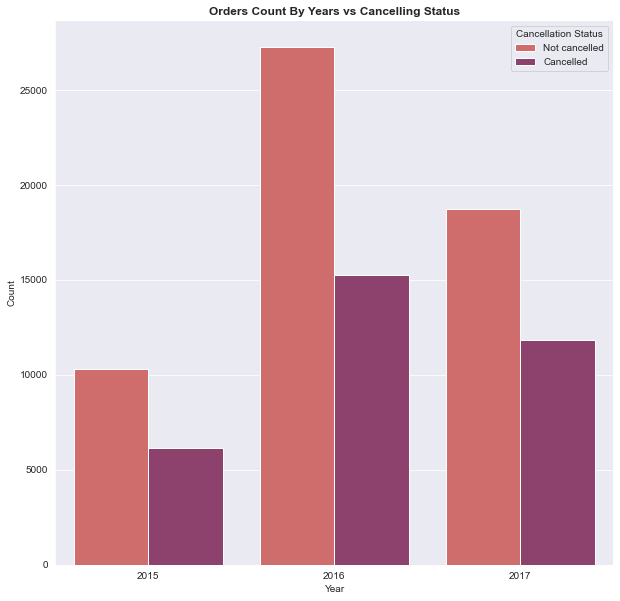

In [19]:
sns.set_style('darkgrid')
fig, bar = plt.subplots(figsize = (10,10))
bar = sns.countplot(x='order_year',hue='cancelation', data= df, palette='flare',
                    orient = 'v')
sns.despine()
bar.set_title('Orders Count By Years vs Cancelling Status', weight='bold')
bar.set_xlabel('Year')
bar.set_ylabel('Count')
bar.legend(title='Cancellation Status', labels=['Not cancelled', 'Cancelled'])
plt.show()

### anon_feat 12 Distribution

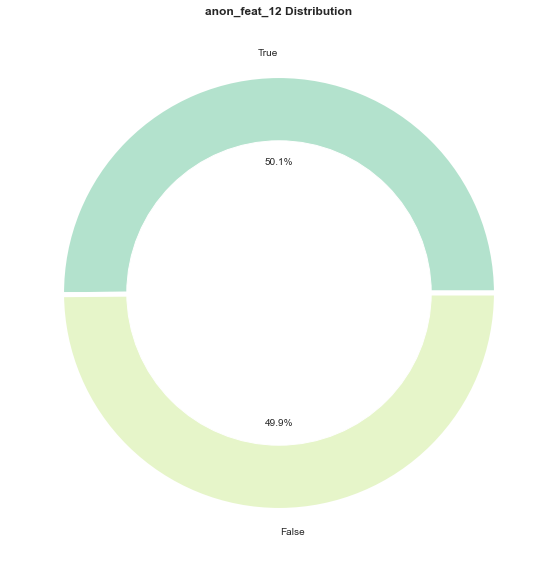

In [20]:
size = df['anon_feat_12'].value_counts()
plt.figure(figsize=(10,10))
cmap =plt.get_cmap("Pastel2")
labels= ['True', 'False']
colors = cmap(np.arange(3)*4)
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, colors=colors, labels=labels,
        wedgeprops = { 'linewidth' : 5, 'edgecolor' : 'white' },
        autopct="%.1f%%")
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('anon_feat_12 Distribution', weight='bold')
plt.show()

We noticed that anon_feat_12 is actually pretty nicely diributed almost exactly 50-50 % .

###  anon_feat 10 explored
We have noticed initially that anon_feat_10 has a certain histogram, here it is displayed with cancellation status

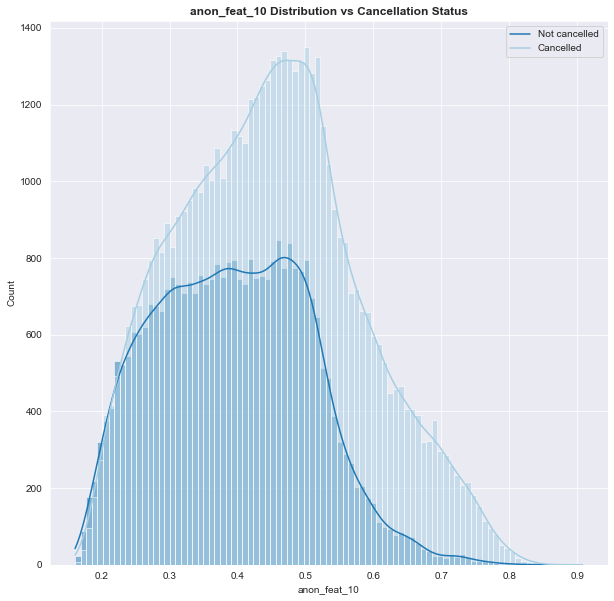

In [21]:
fig, bar = plt.subplots(figsize = (10,10))
sns.histplot(x='anon_feat_10', hue='cancelation', data=df, palette="Paired", kde=True)
plt.title('anon_feat_10 Distribution vs Cancellation Status', weight='bold')
plt.legend(labels=['Not cancelled', 'Cancelled'])
plt.show()

It is interesting to see that people within a certain range of anon_feat_10 display a higher cancelation count. 

###  Prev Canceled Effect on Changes made

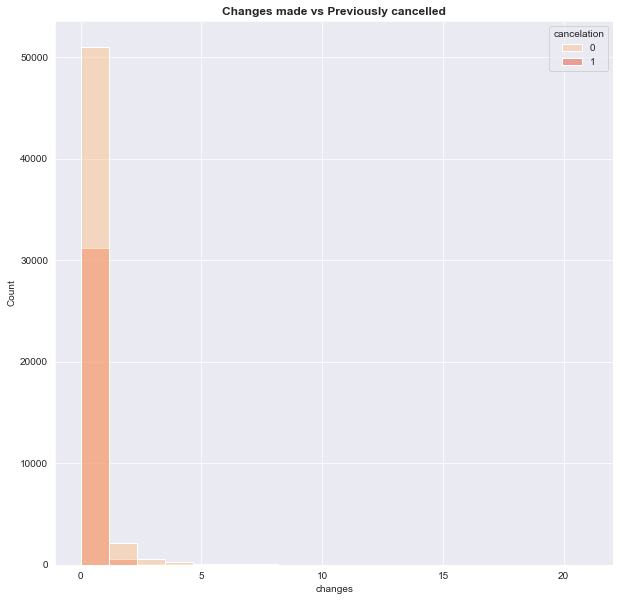

In [22]:

fig, bar = plt.subplots(figsize = (10,10))
histplot = sns.histplot(x='changes', hue='cancelation' ,data=df, palette="OrRd")
plt.title('Changes made vs Previously cancelled', weight='bold')
plt.show()


This plot taought us that there is probably no special correlation between changes made to cancellation. 

### Time Until Order vs Cancellation Status

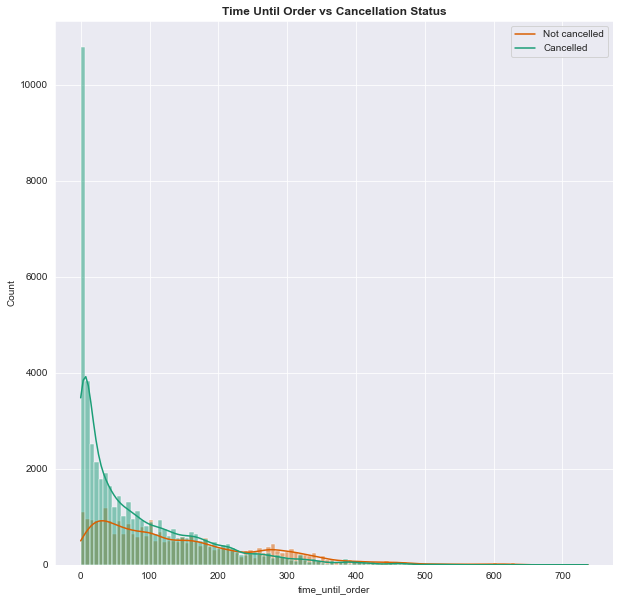

In [23]:
fig, bar = plt.subplots(figsize = (10,10))
sns.histplot(x='time_until_order', hue='cancelation', data=df, palette="Dark2", kde=True)
plt.title('Time Until Order vs Cancellation Status', weight='bold')
plt.legend(labels=['Not cancelled', 'Cancelled'])
plt.show()

###  Top 10 Countries by Orders and Seasons

Text(0, 0.5, 'Count')

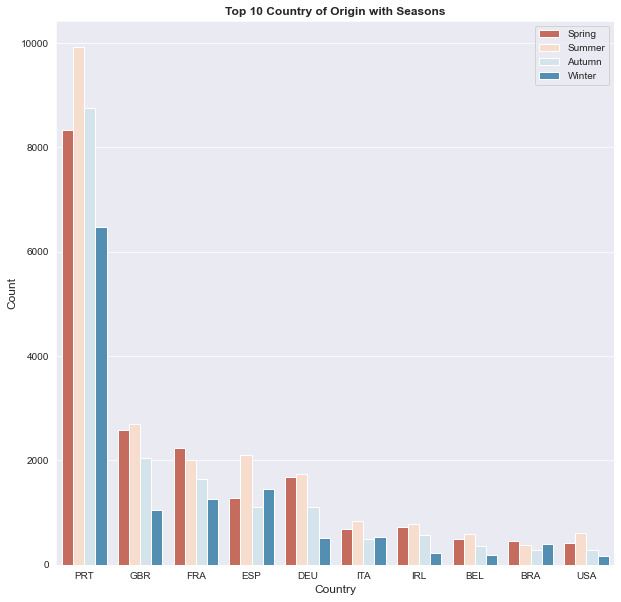

In [24]:
fig, bar = plt.subplots(figsize = (10,10))
sns.countplot(x='country',hue='season', data=df,
              order=pd.value_counts(df['country']).iloc[:10].index, palette="RdBu")
plt.title('Top 10 Country of Origin with Seasons', weight='bold')
plt.legend(labels=[season for season in seasons.values()])
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)

It is interesting to see that a big percent of the orders were made from very few countries.<br>

We are going to use this fact and see what countries had the most orders not cancelled:

In [25]:
# Getting the top 10 Cancelled orders

top_un_cancelled = df[df['cancelation'] == 1]['country'].iloc[:10].tolist()

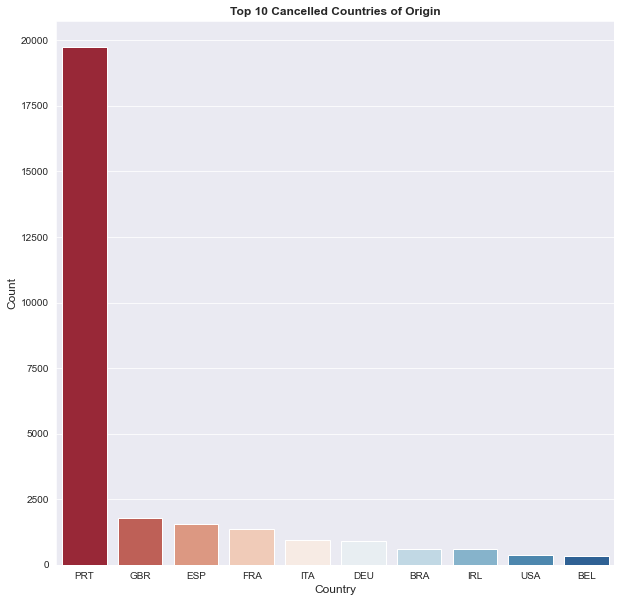

In [26]:
fig, bar = plt.subplots(figsize = (10,10))
sns.countplot(x='country' ,data=df[df['cancelation'] == 1],
              order=pd.value_counts(df[df['cancelation'] == 1]['country']).iloc[:10].index, palette="RdBu")
plt.title('Top 10 Cancelled Countries of Origin', weight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

We notice that there is a built-in problem here - some countries have more orders, and therefore more cancelations. <br>
Some sort of normalization is needed. <br>
To do this, we are going to present an idea: check for each country the ratio between cancellations to orders count, and create
a new numeric feature to replace countries. <br> This numeric feature will be tested against normal encoding later down the road. 

In [27]:
temp = df[df['cancelation'] == 1]
cancel_ratio = temp['country'].value_counts()/df['country'].value_counts()
country_cancel_ratio_key = cancel_ratio.to_dict()
df['country_cancel_ratio'] = df['country'].map(country_cancel_ratio_key)

In [28]:
cancel_ratio.sort_values(ascending=False).head(30).to_frame().T

,NIC,MYT,FJI,KHM,JEY,IMN,HND,BEN,GLP,GGY,...,TZA,AND,NGA,QAT,GIB,MDV,BHR,BGD,SAU,ZWE
country,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.75,0.75,0.695652,0.692308,0.692308,0.666667,0.666667,0.666667,0.666667,0.666667


This is another interesting finding, some countries have a 100% of cancellation ratio.It is not very suprising because as we have learned before, this data has country classifications without many orders, and some countries (like Portugal) with over than half of the orders. 

###  Acquisition Channel vs Cancellation Count

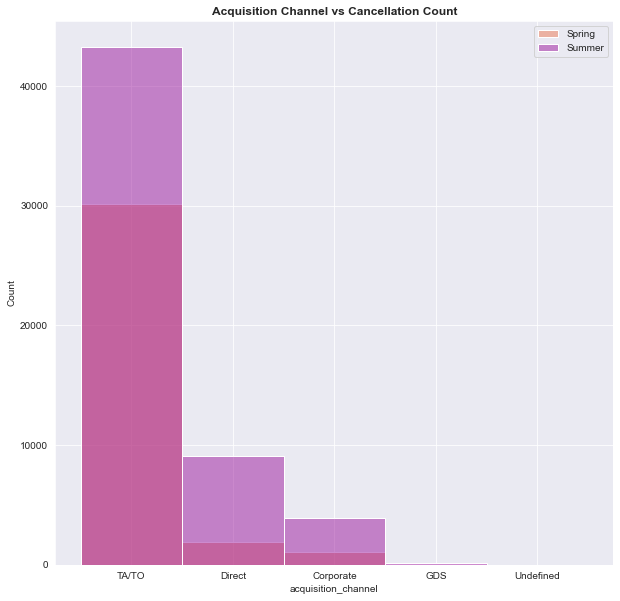

In [29]:
fig, bar = plt.subplots(figsize = (10,10))
sns.histplot(x='acquisition_channel',hue='cancelation', data=df, palette="plasma")
plt.title('Acquisition Channel vs Cancellation Count', weight='bold')
plt.legend(labels=[season for season in seasons.values()])
plt.show()

### Order Type

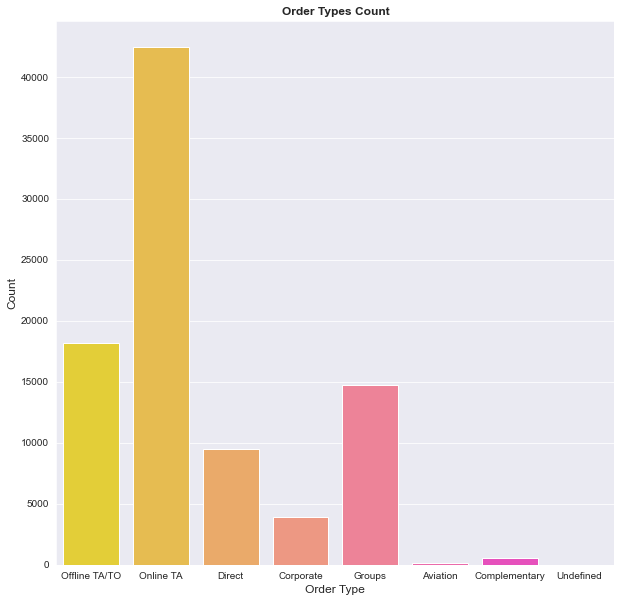

In [30]:
fig, bar = plt.subplots(figsize = (10,10))
sns.countplot(x='order_type',
              palette='spring_r',
              data = df)
plt.title('Order Types Count', weight='bold')
plt.xlabel('Order Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

It is pretty apparent that having both acquisition channel and order type features will
be redundant because they are very similar in content and in values.

# Part 2: Preprocessing <a class="anchor" id="part2"></a>
## Answers for Part 2 questions
<br>
1. People who have deleted their orders more than 20 times.
  family with 10 kids that ordered a hotel
  -those cases are possible but they are outliers, therefore, we moved only the features that have more than 50% missing values
<br>
2. The data is not scaled.  scaling is essential for machine learning algorithms that calculate distances between data.
 If not scale, the feature with a higher value range starts dominating when calculating distances.
<br>
3. There are 253577 missing values in the dataframe. We chose to remove only the features with more than 50% missing values

<br>
4. The problem has more than 30  features for each row. big dimensionality can affect the predictions' accuracy.

## Feature Engineering
### Examining "nan" Data

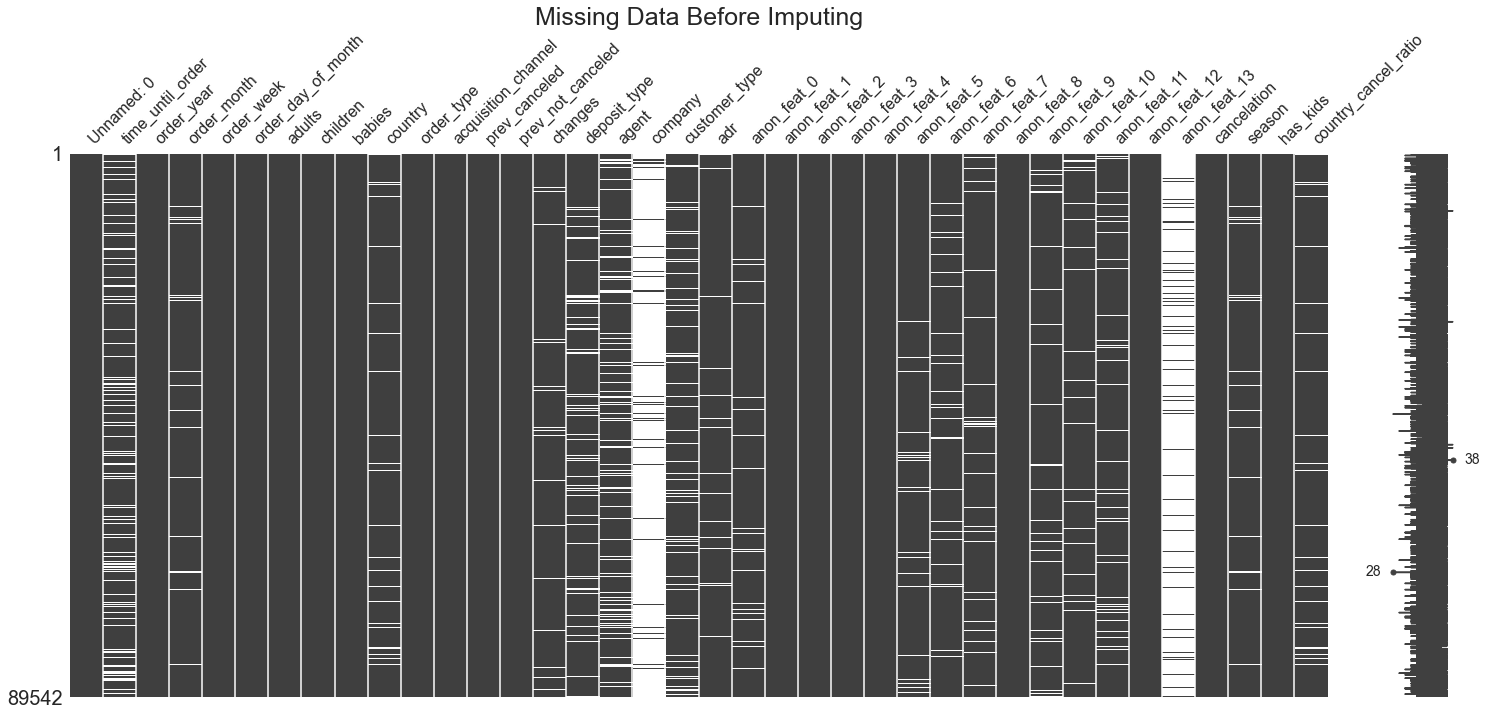

In [31]:
msno.matrix(df)
plt.title('Missing Data Before Imputing', fontsize=25)
plt.show()

In [32]:
null_lst = df.isnull().sum().divide(df.shape[0]).round(2).astype(str) + "%"
null_lst.sort_values(ascending = False)

company                 0.94%
anon_feat_13            0.94%
agent                   0.14%
time_until_order        0.14%
customer_type           0.11%
deposit_type             0.1%
anon_feat_11            0.06%
anon_feat_5             0.05%
anon_feat_6             0.05%
country_cancel_ratio    0.05%
anon_feat_7             0.05%
country                 0.05%
anon_feat_9             0.04%
anon_feat_0             0.04%
changes                 0.04%
order_month             0.04%
season                  0.04%
anon_feat_10            0.03%
adr                     0.03%
prev_not_canceled        0.0%
children                 0.0%
has_kids                 0.0%
order_year               0.0%
cancelation              0.0%
order_week               0.0%
anon_feat_12             0.0%
order_day_of_month       0.0%
adults                   0.0%
anon_feat_8              0.0%
prev_canceled            0.0%
babies                   0.0%
order_type               0.0%
acquisition_channel      0.0%
anon_feat_

The highest values:

The company and anon_feat_13 will be removed during feature selection in the following section. Although 14 percent is quite alot for the other features, it is possible to handle this kind of null percent using imputing after splitting to train and train.

We can observe that the missing values are a very small percent of the data. We searched for the
most common values and used it to fill the missing. 

### Feature Selection
First, after examining the data, we can select some features to drop. this decision does not come by easily, as it represents some loss of information that was gathered.<br>
The features that we have selected to drop were chosen by:

* High null percentages as shown in the previous section (higher than 90% for the dropped features)
* Similar information
* Seasons over order_mont/order_week
* The country feature was removed over for country cancel ratio
* Correlating features which might create distractions over different models. We can recall the previous shown results:

In [33]:
corr = corr[corr!= 1]
corr

time_until_order   anon_feat_11    0.999476
children           has_kids        0.999310
order_month        order_week      0.995450
anon_feat_4        anon_feat_5     0.813804
prev_not_canceled  anon_feat_3     0.755504
agent              anon_feat_9     0.713712
dtype: float64

We also chose the features showing the higher correlations to the cancelling situation, leaving us with:
* Children over has_kids
* anon_feat_5 over anon_feat_4
* anon_feat 3 over prev_not_canceled 
* anon_feat_9 over agent

In addition:
* Season over order_month

The better correlated feature will remain, the others will be dropped.

In [34]:
features_dropped = ['Unnamed: 0','has_kids', 'babies',
                    'order_week', 'order_month', 'order_day_of_month',
                    'anon_feat_11', 'order_type','country', "anon_feat_13",
                   'anon_feat_4', 'prev_not_canceled', 'agent', 'company']

categorical_cols_for_encode = ['acquisition_channel', #'order_year', 'season',
                               'customer_type','deposit_type']


In [35]:
def feature_selection(df, drop_labels=True):
    df = df.drop(features_dropped, axis='columns')
    if drop_labels == True:
        df = df.drop('cancelation', axis='columns')
    return df

And now we would like to distinct our final df for modeling:

In [36]:
df_selected = feature_selection(df)
df_selected

,time_until_order,order_year,adults,children,acquisition_channel,prev_canceled,changes,deposit_type,customer_type,adr,...,anon_feat_3,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_12,season,country_cancel_ratio
0,309.0,2016,2,0.0,TA/TO,0,0.0,No Deposit,Transient-Party,101.0,...,0,0.0,215.0,0.0,0,0.0,0.250606,1,1.0,0.567291
1,3.0,2016,2,0.0,TA/TO,0,0.0,NaN,Transient,101.0,...,0,3.0,0.0,1.0,1,1.0,0.444719,1,3.0,0.249595
2,NaN,2017,1,0.0,Direct,0,0.0,No Deposit,Transient-Party,80.0,...,1,4.0,0.0,0.0,0,1.0,0.598733,1,1.0,0.172538
3,153.0,2015,2,0.0,TA/TO,0,1.0,No Deposit,Contract,8054.0,...,0,3.0,0.0,0.0,0,1.0,0.335675,1,3.0,0.204357
4,33.0,2016,2,0.0,Corporate,0,1.0,No Deposit,NaN,64.0,...,0,0.0,15.0,0.0,0,0.0,0.492874,1,4.0,0.376324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89537,21.0,2017,2,0.0,TA/TO,0,0.0,No Deposit,NaN,1575.0,...,0,0.0,0.0,0.0,1,0.0,0.321296,1,1.0,0.242298
89538,90.0,2016,2,0.0,TA/TO,0,0.0,No Deposit,Transient,9095.0,...,0,0.0,0.0,0.0,1,0.0,0.398224,0,1.0,0.172538
89539,39.0,2015,1,0.0,TA/TO,0,0.0,No Deposit,Transient,1296.0,...,0,0.0,0.0,0.0,1,1.0,0.387626,0,2.0,0.567291
89540,110.0,2015,2,0.0,TA/TO,0,0.0,No Deposit,Transient,134.0,...,0,0.0,0.0,0.0,1,1.0,0.323147,1,NaN,0.567291


## Data Split, Imputation and Scaling
First, from now on our data will be split to train and test datasets

### Splitting the Data

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_selected, y['cancelation'], test_size=0.33, random_state=42)

### Dealing with Categorical Data
We have examined three methods of encoding the data, reviewed modeling performances for each one and chose to present the preffered method here alone. We have checked:
* Label encoding .
* OneHotEncoder over the entire df including the country variable (creating around 160 features in a total).
* OneHotEncoder using the country_cancel_ratio feature, reducing dramatically the number of dimensions - this method produced the highest modeling results. 

The whole process is described in our additional report including the code for the different encoding. 

In [38]:
enc = ce.OneHotEncoder(cols = categorical_cols_for_encode)
enc = enc.fit(X_train)

In [39]:
def hot_enc_ratio(X):
    df_bin = enc.transform(X)
    return df_bin

In [40]:
X_train, X_test = map(hot_enc_ratio, [X_train, X_test])

### Imputation

The imputation of missing values will be done using the most common values in each row of the train set, later the imputation's object fit will be used in order to impute the test and submissin datasets. The most common values of each feature:


In [41]:
X_train.mode().head(1).squeeze()

time_until_order            0.000000
order_year               2016.000000
adults                      2.000000
children                    0.000000
acquisition_channel_1       1.000000
acquisition_channel_2       0.000000
acquisition_channel_3       0.000000
acquisition_channel_4       0.000000
acquisition_channel_5       0.000000
prev_canceled               0.000000
changes                     0.000000
deposit_type_1              0.000000
deposit_type_2              1.000000
deposit_type_3              0.000000
deposit_type_4              0.000000
customer_type_1             1.000000
customer_type_2             0.000000
customer_type_3             0.000000
customer_type_4             0.000000
customer_type_5             0.000000
adr                        62.000000
anon_feat_0                 0.000000
anon_feat_1                 2.000000
anon_feat_2                 0.000000
anon_feat_3                 0.000000
anon_feat_5                 0.000000
anon_feat_6                 0.000000
a

The imputation is done feature by feature, while the fit is set to the train set. <br>
the imputation will be used both for test and submission sets based on this fit. The imputation itself will be done later via a pipeline.

In [42]:
#Data imputer class

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [43]:
def impute_data(x_to_transform):
    for feature in x_to_transform.columns:
        imputer.fit(X_train[feature].values.reshape(-1,1))
        x_to_transform[feature] = imputer.transform(x_to_transform[feature].values.reshape(-1,1))
    return x_to_transform

In [44]:
X_train, X_test = map(impute_data, [X_train, X_test])

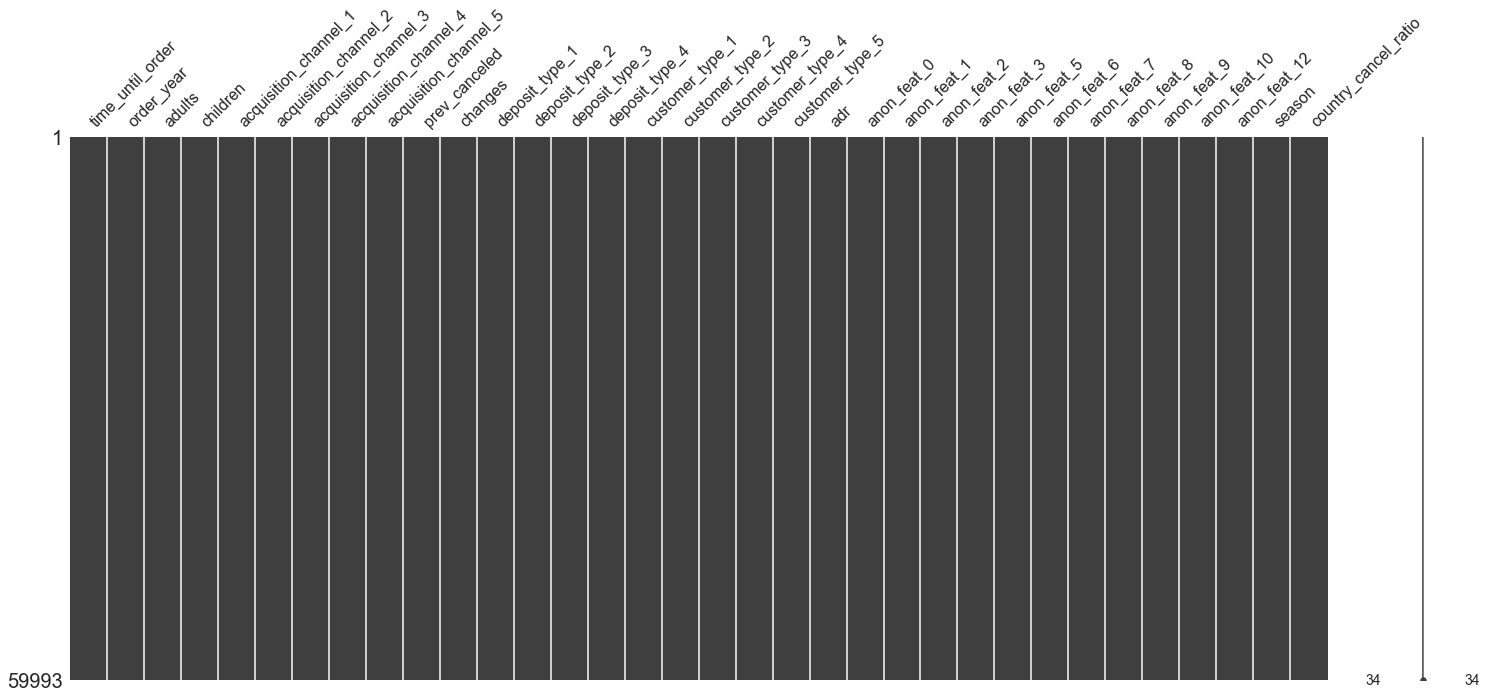

In [45]:
msno.matrix(X_train)
plt.show()

**Note: Both validation and train sets are imputed, but the train set uses to fit the imputation!** 

## Dealing with outliers
We have seen some outlier values during the exploration stages. Therefore, we would deal with such values using the "Zscores" method displayed below.

In [46]:
X_comp = X_train
display(X_train.shape, y_train.shape)

(59993, 34)

(59993,)

In [47]:
def remove_outliers(X_train, y_train):
    z = np.abs(stats.zscore(X_train))
    idx = np.all(z<6, axis = 1)
    X_clean = X_train[(z<6).all(axis=1)]
    y_train = y_train.iloc[idx]
    return X_clean, y_train

In [48]:
X_train, y_train = remove_outliers(X_train, y_train)

In [49]:
display(X_train.shape, y_train.shape)

(58796, 34)

(58796,)

We have looked for a method that would not cut through too much data, and yet will be able to remove some outlier features.
Therefore, we have set a threshold of Zscore < 6 after searching an optimal value. <br>

In [50]:
diff_df = pd.merge(X_train, X_comp, how='outer', indicator='Exist')
diff_df = diff_df.loc[diff_df['Exist'] != 'both']
diff_df

,time_until_order,order_year,adults,children,acquisition_channel_1,acquisition_channel_2,acquisition_channel_3,acquisition_channel_4,acquisition_channel_5,prev_canceled,...,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_12,season,country_cancel_ratio,Exist
58838,126.0,2017,2,0.0,1,0,0,0,0,0,...,3.0,0.0,0.0,1,1.0,0.372728,1,2.0,0.204357,right_only
58839,0.0,2016,1,0.0,1,0,0,0,0,0,...,0.0,63.0,0.0,0,0.0,0.402659,1,4.0,0.409091,right_only
58840,0.0,2016,2,0.0,1,0,0,0,0,0,...,0.0,236.0,0.0,0,0.0,0.496785,1,1.0,0.183136,right_only
58841,169.0,2016,2,0.0,0,1,0,0,0,0,...,0.0,0.0,0.0,0,1.0,0.206094,1,1.0,0.190225,right_only
58842,0.0,2016,1,0.0,0,0,1,0,0,0,...,1.0,0.0,0.0,0,0.0,0.736873,1,3.0,0.567291,right_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60030,238.0,2017,2,2.0,1,0,0,0,0,0,...,6.0,0.0,0.0,0,1.0,0.307788,0,2.0,0.183136,right_only
60031,2.0,2017,2,0.0,1,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.475937,0,2.0,0.183136,right_only
60032,95.0,2017,2,1.0,0,1,0,0,0,0,...,5.0,0.0,1.0,3,1.0,0.477147,0,2.0,0.567291,right_only
60033,0.0,2017,0,0.0,1,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.732108,0,1.0,0.567291,right_only


As seen above promptly, Those are the removed outliers by zscore.

## Scaling the Data for PCA, Setting Up Imputers
We are going to run the standard scaler inside the pipeline, right now we are going to use it only for showing the methodology and comapring PCA dimensioality reduction.

In [51]:
num_features = ['time_until_order', 'adults',
                'children', 'changes', 'adr',
                'prev_canceled', 'anon_feat_0', 'anon_feat_1', 
                'anon_feat_2', 'anon_feat_5', 'anon_feat_8',
                'anon_feat_10', 'country_cancel_ratio']
    
cat_features = [i for i in X_train.columns.to_list() if (i not in  num_features)]


In [52]:
X_train_num = X_train[num_features]
standardScalerX = StandardScaler()
standardScalerX.fit(X_train_num)

def scale_data(X):
    X_num = X[num_features]
    X_num = standardScalerX.transform(X_num)
    X_scaled = X
    X_scaled.loc[:,num_features] = standardScalerX.transform(X_scaled.loc[:,num_features])
    return X_scaled

In [53]:
# Build PCA for numeric features, will be used only here -later via pipeline
pca = PCA()
data_for_PCA = (X_train_num-X_train_num.mean()/(X_train_num.std()))
pca.fit(X_train_num)

PCA()

In [54]:
X_train_pca = pca.transform(data_for_PCA)

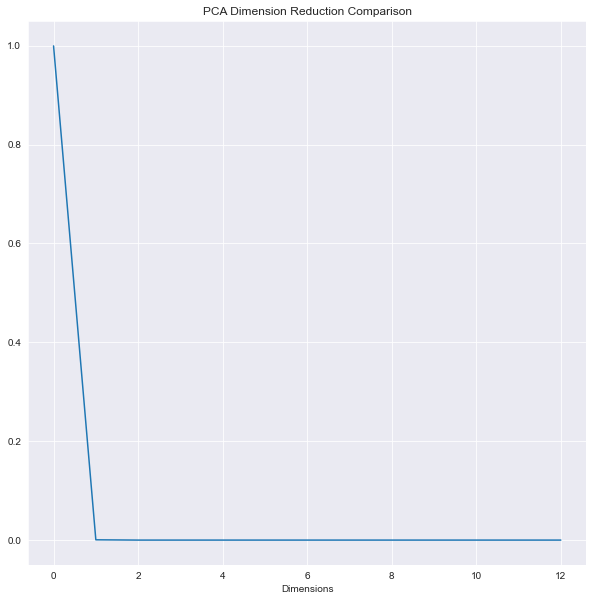

In [55]:
# Show the PCA comparison
plt.figure(figsize=(10,10))
plt.plot(pca.explained_variance_ratio_)
plt.title('PCA Dimension Reduction Comparison')
plt.xlabel('Dimensions')
plt.show()

This is an indication to the fact that PCA might be used to increase the accuracy of the models later, seeing that down to around 1 dimension (for numeric features) there is a small impact.
That being said, we have tested multiple variations of the modeling, and based on our understanding of those models as well, we will compare the use of PCA only for the Logistic Regression Model. It will be used integrally via piplines.

Creating a preprocessor function to be used later

In [100]:
def preprocessor(df):
    df['country_cancel_ratio'] = df['country'].map(country_cancel_ratio_key)
    func = [numbers_to_str, new_features] 
    for f in func:
        df = f(df)
    df = feature_selection(df, drop_labels=False)
    df = hot_enc_ratio(df)
    df = impute_data(df)
    return df

process_pipe = FunctionTransformer(preprocessor)

In [57]:
scaler = Pipeline(steps=[('sca', StandardScaler())])

scaler_pca = Pipeline(steps=[('sca', StandardScaler()),
                            ('PCA', PCA(n_components=5))])

scaler_pipe = ColumnTransformer(transformers = [
    ('sca', scaler , num_features)], remainder='passthrough')

scaler_pca_pipe = ColumnTransformer(transformers = [
    ('sca', scaler_pca , num_features)], remainder='passthrough')

# Part 3: Modelling <a class="anchor" id="part3"></a>

## Naive Comparison
At this stage we have the data explored, and we have a few suggestions on how to make reliable predictions. In order to fine tune it and put it to a test, we must compare several modeling estimators. <br>
We chose to run a naive test on a few of those classifiers, and later on we would hyper-tune their parameters in order to get the best results.

In [58]:
LGR_pipe = Pipeline([('sca', scaler_pipe),
                     ('LGR', LogisticRegression())])

KNN_pipe = Pipeline([('sca', scaler_pipe),
                     ('KNN', KNeighborsClassifier(algorithm='brute'))])

RFC_pipe = Pipeline([('RFC', RandomForestClassifier())])

MLP_pipe = Pipeline([('MLP', MLPClassifier())])

# LGR_PCA = Pipeline([('sca', scaler_pca_pipe),
#                     ('pca', PCA(n_components=2)),
#                      ('LGR', LogisticRegression())])

In [59]:
classifiers = [
    ('LGR', LGR_pipe),
    ('KNN', KNN_pipe),
    ('RFC', RFC_pipe),
    ('MLP', MLP_pipe)
#     ('LGR_PCA', LGR_PCA)
    ]

Let's fit the models to the train data one by one:

In [60]:
for model_name, model in tqdm(classifiers):
    model.fit(X_train, y_train)

100%|██████████| 4/4 [00:12<00:00,  3.03s/it]


In [61]:
# Checking for the train and test data

preds_train = {}
preds_test = {}

for name, model in tqdm(classifiers):
    preds_train[name] = model.predict(X_train)
    print(name, "Train Data", classification_report(y_train, preds_train[name]))
    preds_test[name] = model.predict(X_test)
    print(name, "Test Data", classification_report(y_test, preds_test[name]))
    

 25%|██▌       | 1/4 [00:00<00:00,  6.63it/s]

LGR Train Data               precision    recall  f1-score   support

           0       0.79      0.90      0.84     37071
           1       0.77      0.59      0.67     21725

    accuracy                           0.79     58796
   macro avg       0.78      0.75      0.76     58796
weighted avg       0.78      0.79      0.78     58796

LGR Test Data               precision    recall  f1-score   support

           0       0.79      0.90      0.84     18494
           1       0.78      0.60      0.67     11055

    accuracy                           0.78     29549
   macro avg       0.78      0.75      0.76     29549
weighted avg       0.78      0.78      0.78     29549

KNN Train Data               precision    recall  f1-score   support

           0       0.88      0.92      0.90     37071
           1       0.85      0.78      0.81     21725

    accuracy                           0.87     58796
   macro avg       0.86      0.85      0.85     58796
weighted avg       0.86      0

 50%|█████     | 2/4 [01:24<01:39, 49.83s/it]

KNN Test Data               precision    recall  f1-score   support

           0       0.82      0.87      0.84     18494
           1       0.75      0.69      0.72     11055

    accuracy                           0.80     29549
   macro avg       0.79      0.78      0.78     29549
weighted avg       0.80      0.80      0.80     29549

RFC Train Data               precision    recall  f1-score   support

           0       1.00      1.00      1.00     37071
           1       1.00      1.00      1.00     21725

    accuracy                           1.00     58796
   macro avg       1.00      1.00      1.00     58796
weighted avg       1.00      1.00      1.00     58796



 75%|███████▌  | 3/4 [01:26<00:27, 27.87s/it]

RFC Test Data               precision    recall  f1-score   support

           0       0.84      0.93      0.89     18494
           1       0.86      0.71      0.78     11055

    accuracy                           0.85     29549
   macro avg       0.85      0.82      0.83     29549
weighted avg       0.85      0.85      0.85     29549

MLP Train Data               precision    recall  f1-score   support

           0       0.87      0.67      0.76     37071
           1       0.60      0.83      0.70     21725

    accuracy                           0.73     58796
   macro avg       0.74      0.75      0.73     58796
weighted avg       0.77      0.73      0.74     58796



100%|██████████| 4/4 [01:26<00:00, 21.67s/it]

MLP Test Data               precision    recall  f1-score   support

           0       0.87      0.67      0.76     18494
           1       0.60      0.84      0.70     11055

    accuracy                           0.73     29549
   macro avg       0.74      0.75      0.73     29549
weighted avg       0.77      0.73      0.73     29549



In [62]:
def model_compare(X, y, classifiers, name= ""):
    
    res = pd.DataFrame()
    
    kfold = model_selection.KFold(n_splits=5)
    
    for model_name, model in tqdm(classifiers):
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        msg = "{} cross validation accuracy score: {:.3f} +/- {:.3f} (STD) \n Min Score: {:.3f}, Max Score: {:.3f}".format(type(model[model_name]).__name__, cv_results.mean(), cv_results.std(), cv_results.min(), cv_results.max())
        print(msg)
        cv_results = pd.Series(cv_results)
        res[model_name] = cv_results
    res["type"] = name
    return res
      

In [63]:
res_naive_train = model_compare(X_train, y_train, classifiers, name = "Train")
res_naive_test = model_compare(X_test, y_test, classifiers, name = "Test")

 25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

LogisticRegression cross validation accuracy score: 0.786 +/- 0.004 (STD) 
 Min Score: 0.779, Max Score: 0.792


 50%|█████     | 2/4 [00:47<00:54, 27.32s/it]

KNeighborsClassifier cross validation accuracy score: 0.799 +/- 0.004 (STD) 
 Min Score: 0.792, Max Score: 0.804


 75%|███████▌  | 3/4 [01:08<00:24, 24.64s/it]

RandomForestClassifier cross validation accuracy score: 0.845 +/- 0.004 (STD) 
 Min Score: 0.839, Max Score: 0.850


  0%|          | 0/4 [00:00<?, ?it/s]

MLPClassifier cross validation accuracy score: 0.707 +/- 0.071 (STD) 
 Min Score: 0.573, Max Score: 0.768


 25%|██▌       | 1/4 [00:02<00:06,  2.13s/it]

LogisticRegression cross validation accuracy score: 0.786 +/- 0.004 (STD) 
 Min Score: 0.779, Max Score: 0.792


 50%|█████     | 2/4 [00:43<00:50, 25.09s/it]

KNeighborsClassifier cross validation accuracy score: 0.799 +/- 0.004 (STD) 
 Min Score: 0.792, Max Score: 0.804


 75%|███████▌  | 3/4 [01:02<00:22, 22.24s/it]

RandomForestClassifier cross validation accuracy score: 0.846 +/- 0.003 (STD) 
 Min Score: 0.841, Max Score: 0.848


100%|██████████| 4/4 [01:26<00:00, 21.60s/it]

MLPClassifier cross validation accuracy score: 0.754 +/- 0.038 (STD) 
 Min Score: 0.698, Max Score: 0.800


In [64]:
def plot_compare(lst):
    con = pd.concat(lst)
    value_vars = con.columns.to_list()
    value_vars.pop()
    con = pd.melt(con, id_vars=['type'], value_vars=value_vars, var_name='model')
    plt.plot
    fig, bar = plt.subplots(figsize = (20,10))
    sns.set_theme(style="whitegrid")
    box = sns.boxplot(x='model', y='value', data=con, hue='type')
    plt.title('Comparing Models Scoring by CV Score')
    plt.legend(title='Data Set')
    plt.show


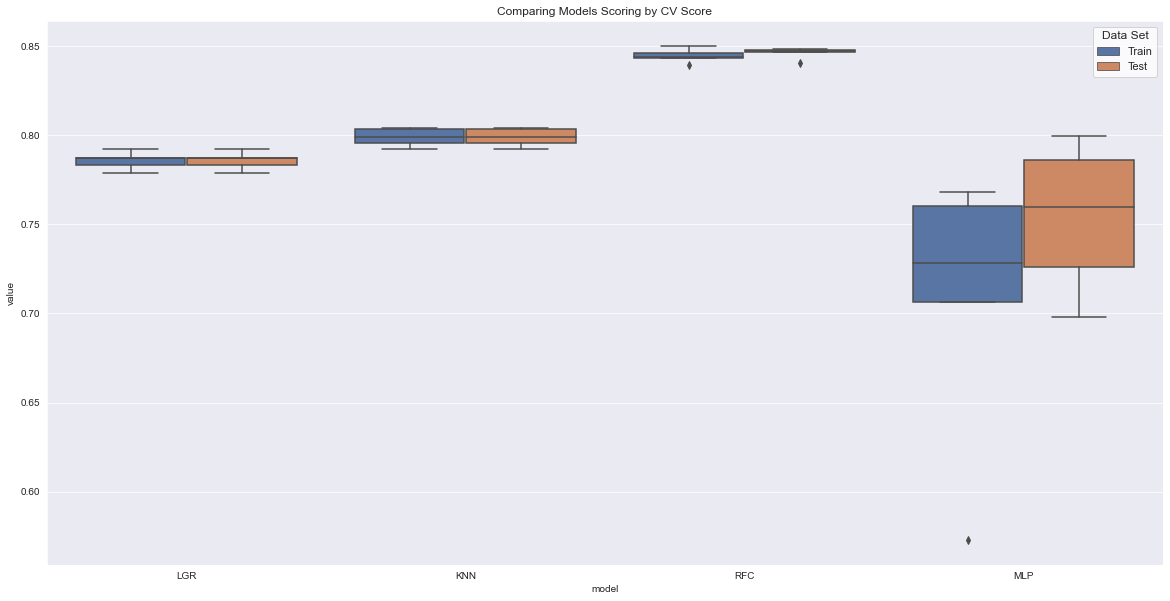

In [65]:
plot_compare([res_naive_train, res_naive_test])

In [66]:
display("Test means - Naive:", res_naive_test.mean(),"Train means - Naive:" , res_naive_train.mean())

'Test means - Naive:'

LGR    0.785904
KNN    0.798949
RFC    0.846095
MLP    0.753946
dtype: float64

'Train means - Naive:'

LGR    0.785904
KNN    0.798949
RFC    0.844700
MLP    0.707207
dtype: float64

The plot and the above list shows the scores, and their comparison of the CV score results between un-tuned classifiers. <br> It is obvious already at this point what classifier will be the most fitting for our data. We would like to make a one final check before calling a winner by checking what score would a "dumb" classifier revice, meaning if a classiffier will always predict cancelation we would get:

In [67]:
print('"Dumb" Classifier score: {0:.2%}"'.format(y['cancelation'][y['cancelation'] == 0].count()/y.shape[0]))

"Dumb" Classifier score: 62.93%"


We can note that even in the "Naive" configuration, the models perform quite good, without signs of "overfitting" and with very similar results for both train and test data. It is also very clear that all the tested models are better than a "dumb" classifier.


### Hyperparameter Tuning

We are going to run the following classifiers:

In [68]:
search_params = {
    'KNN': {'KNN__n_neighbors': list(range(1,31)),
#             'KNN__weights': ['uniform, distance'],
            'KNN__metric': ['euclidean', 'manhattan']},
    'RFC': {'RFC__n_estimators' : list(range(150,260,10)),
            'RFC__min_samples_split' : [2,4,6,8],
            'RFC__min_samples_leaf': [1,2,4,6],
            'RFC__max_features': ['auto' , 'sqrt', 'log2'],
            },
    'MLP': {'MLP__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
           'MLP__activation': ['tanh', 'relu'],
           'MLP__solver': ['sgd', 'adam'],
           'MLP__alpha': [0.0001, 0.05],
           'MLP__learning_rate': ['constant','adaptive']},
#             'LGR_PCA': [],
            'LGR' : {'LGR__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    }


def hyper_parameters(X_train, y_train, classifiers):
    param_res = {}
    classifiers_opt = []
    i = 0
    for model_name, model in tqdm(classifiers):
        param_grid = search_params[model_name]
        grid = GridSearchCV(model, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1)
        grid_result = grid.fit(X_train, y_train)
        opt_model = model.set_params(**grid_result.best_params_) 
        classifiers_opt.append((model_name, opt_model))
        param_res[model_name] = grid_result.best_params_ 
        i+=1
    return param_res, classifiers_opt
            

In [69]:
%%script false
# param_res, classifiers_opt = hyper_parameters(X_train, y_train, classifiers)
# %store classifiers_opt
# %store param_res

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 7 candidates, totalling 35 fits


 25%|██▌       | 1/4 [00:08<00:26,  8.87s/it]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


 50%|█████     | 2/4 [22:47<26:45, 802.68s/it]

Fitting 5 folds for each of 528 candidates, totalling 2640 fits


 75%|███████▌  | 3/4 [1:22:24<34:29, 2069.65s/it]

Fitting 5 folds for each of 48 candidates, totalling 240 fits


100%|██████████| 4/4 [1:40:36<00:00, 1509.14s/it]


Stored 'classifiers_opt' (list)
Stored 'param_res' (dict)


In [70]:
%store -r classifiers_opt
%store -r param_res

In [71]:
param_res

{'LGR': {'LGR__C': 0.001},
 'KNN': {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 22},
 'RFC': {'RFC__max_features': 'auto',
  'RFC__min_samples_leaf': 1,
  'RFC__min_samples_split': 2,
  'RFC__n_estimators': 230},
 'MLP': {'MLP__activation': 'relu',
  'MLP__alpha': 0.0001,
  'MLP__hidden_layer_sizes': (50, 100, 50),
  'MLP__learning_rate': 'adaptive',
  'MLP__solver': 'adam'}}

# Part 4: Evaluating the Models <a class="anchor" id="part4"></a>

### Comparing Grid Results to Base Classifiers

The result DF of GridSearchCV will be now compared to the classifiers mean score before the tuning:

In [72]:
res_search_test = model_compare(X_train, y_train, classifiers_opt, name = "Test-Tuned")
res_search_train = model_compare(X_train, y_train, classifiers_opt, name = "Train-Tuned")

 25%|██▌       | 1/4 [00:01<00:04,  1.63s/it]

LogisticRegression cross validation accuracy score: 0.787 +/- 0.005 (STD) 
 Min Score: 0.781, Max Score: 0.793


 50%|█████     | 2/4 [01:38<01:55, 57.81s/it]

KNeighborsClassifier cross validation accuracy score: 0.819 +/- 0.003 (STD) 
 Min Score: 0.814, Max Score: 0.824


 75%|███████▌  | 3/4 [02:28<00:54, 54.22s/it]

RandomForestClassifier cross validation accuracy score: 0.847 +/- 0.003 (STD) 
 Min Score: 0.843, Max Score: 0.852


  0%|          | 0/4 [00:00<?, ?it/s]

MLPClassifier cross validation accuracy score: 0.792 +/- 0.002 (STD) 
 Min Score: 0.790, Max Score: 0.796


 25%|██▌       | 1/4 [00:01<00:05,  1.86s/it]

LogisticRegression cross validation accuracy score: 0.787 +/- 0.005 (STD) 
 Min Score: 0.781, Max Score: 0.793


 50%|█████     | 2/4 [01:34<01:50, 55.44s/it]

KNeighborsClassifier cross validation accuracy score: 0.819 +/- 0.003 (STD) 
 Min Score: 0.814, Max Score: 0.824


 75%|███████▌  | 3/4 [02:20<00:50, 50.86s/it]

RandomForestClassifier cross validation accuracy score: 0.845 +/- 0.003 (STD) 
 Min Score: 0.840, Max Score: 0.849


100%|██████████| 4/4 [06:15<00:00, 93.85s/it] 

MLPClassifier cross validation accuracy score: 0.794 +/- 0.009 (STD) 
 Min Score: 0.781, Max Score: 0.808


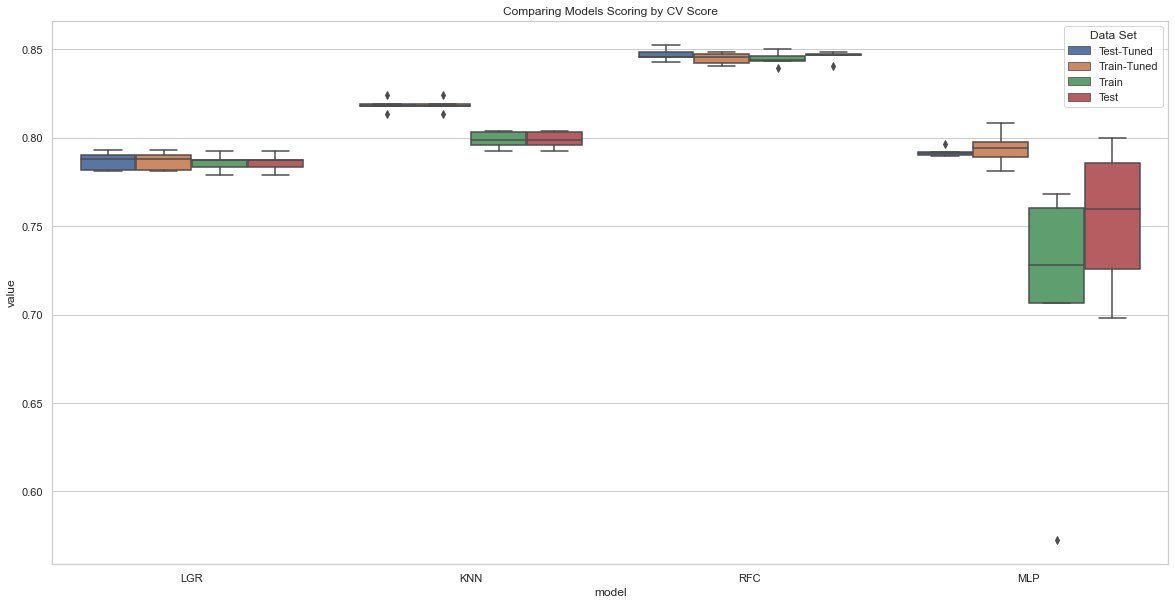

In [73]:
plot_compare([res_search_test, res_search_train, res_naive_train, res_naive_test])

Showing comparison of mean AUC scores before and after grid search hyper-tuning

In [74]:
display("Test means - Tuned:", res_search_test.mean(),"Train means - Tuned:" , res_search_train.mean())

'Test means - Tuned:'

LGR    0.786907
KNN    0.818746
RFC    0.847081
MLP    0.792061
dtype: float64

'Train means - Tuned:'

LGR    0.786907
KNN    0.818746
RFC    0.844904
MLP    0.794119
dtype: float64

In [75]:
display("Test means - Naive:", res_naive_test.mean(),"Train means - Naive:" , res_naive_train.mean())

'Test means - Naive:'

LGR    0.785904
KNN    0.798949
RFC    0.846095
MLP    0.753946
dtype: float64

'Train means - Naive:'

LGR    0.785904
KNN    0.798949
RFC    0.844700
MLP    0.707207
dtype: float64

### Features scoring

We will now perform another check on the number of features that we chose to include, using the model with the highest score - RFC:

In [76]:
# define number of features to evaluate
num_features = [i+1 for i in range(X_train.shape[1])]
# enumerate each number of features
results = list()

In [79]:
%%script false
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores

for k in tqdm(num_features):
    # Choose model
    model = classifiers_opt[2][1]
    fs = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline(steps=[('anova',fs), ('rf', model)])
    # evaluate the model
    scores = evaluate_model(pipeline, X_train, y_train)
    results.append(scores)
    # summarize the results
    print('>%d %.3f (%.3f)' % (k, np.mean(scores), np.std(scores)))

  3%|▎         | 1/34 [00:11<06:11, 11.25s/it]

>1 0.647 (0.005)


  6%|▌         | 2/34 [00:19<05:11,  9.74s/it]

>2 0.659 (0.006)


  9%|▉         | 3/34 [00:32<05:48, 11.23s/it]

>3 0.738 (0.007)


 12%|█▏        | 4/34 [01:01<08:59, 17.97s/it]

>4 0.782 (0.007)


 15%|█▍        | 5/34 [01:30<10:38, 22.01s/it]

>5 0.789 (0.006)


 18%|█▊        | 6/34 [02:00<11:29, 24.61s/it]

>6 0.795 (0.006)


 21%|██        | 7/34 [02:30<11:54, 26.45s/it]

>7 0.814 (0.006)


 24%|██▎       | 8/34 [03:17<14:15, 32.90s/it]

>8 0.805 (0.005)


 26%|██▋       | 9/34 [04:08<16:09, 38.77s/it]

>9 0.817 (0.004)


 29%|██▉       | 10/34 [05:00<17:08, 42.86s/it]

>10 0.828 (0.005)


 32%|███▏      | 11/34 [05:51<17:18, 45.17s/it]

>11 0.837 (0.005)


 35%|███▌      | 12/34 [06:42<17:16, 47.12s/it]

>12 0.838 (0.005)


 38%|███▊      | 13/34 [07:31<16:39, 47.60s/it]

>13 0.847 (0.004)


 41%|████      | 14/34 [08:18<15:50, 47.51s/it]

>14 0.867 (0.005)


 44%|████▍     | 15/34 [09:05<14:59, 47.34s/it]

>15 0.870 (0.004)


 47%|████▋     | 16/34 [09:58<14:42, 49.03s/it]

>16 0.873 (0.004)


 50%|█████     | 17/34 [10:51<14:12, 50.14s/it]

>17 0.876 (0.009)


 53%|█████▎    | 18/34 [11:44<13:38, 51.13s/it]

>18 0.881 (0.014)


 56%|█████▌    | 19/34 [12:40<13:08, 52.58s/it]

>19 0.903 (0.004)


 59%|█████▉    | 20/34 [13:37<12:35, 53.98s/it]

>20 0.904 (0.004)


 62%|██████▏   | 21/34 [14:36<11:59, 55.32s/it]

>21 0.910 (0.004)


 65%|██████▍   | 22/34 [15:33<11:09, 55.78s/it]

>22 0.912 (0.004)


 68%|██████▊   | 23/34 [16:30<10:18, 56.27s/it]

>23 0.914 (0.003)


 71%|███████   | 24/34 [17:28<09:26, 56.62s/it]

>24 0.918 (0.004)


 74%|███████▎  | 25/34 [18:31<08:48, 58.71s/it]

>25 0.922 (0.003)


 76%|███████▋  | 26/34 [19:34<08:00, 60.01s/it]

>26 0.922 (0.003)


 79%|███████▉  | 27/34 [20:39<07:09, 61.35s/it]

>27 0.922 (0.004)


 82%|████████▏ | 28/34 [21:42<06:11, 61.95s/it]

>28 0.921 (0.003)


 85%|████████▌ | 29/34 [22:46<05:12, 62.47s/it]

>29 0.921 (0.004)


 88%|████████▊ | 30/34 [23:49<04:11, 62.84s/it]

>30 0.922 (0.003)


 91%|█████████ | 31/34 [24:53<03:08, 62.92s/it]

>31 0.922 (0.003)


 94%|█████████▍| 32/34 [25:55<02:05, 62.77s/it]

>32 0.922 (0.003)


 97%|█████████▋| 33/34 [26:57<01:02, 62.49s/it]

>33 0.922 (0.003)


100%|██████████| 34/34 [27:58<00:00, 49.36s/it]

>34 0.922 (0.003)


In [108]:
# %store results

Stored 'results' (list)


In [80]:
# %%script false
# plot model performance for comparison
%store -r results
check = True

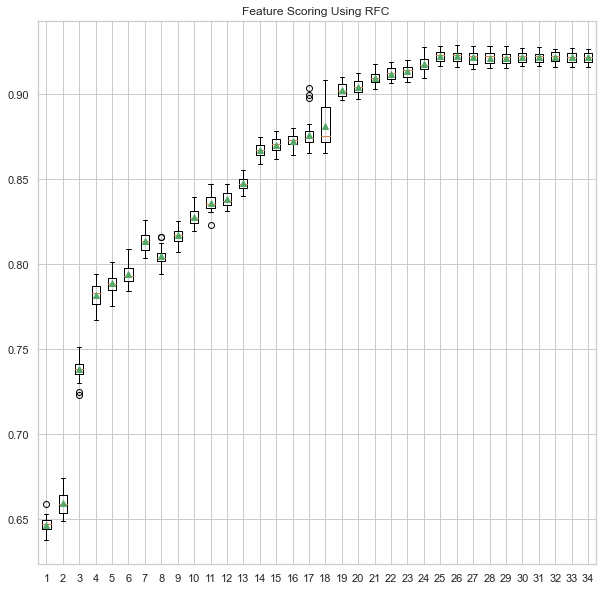

In [81]:
plt,figure(figsize=(10,10))
plt.boxplot(results, labels=num_features, showmeans=True)
plt.title("Feature Scoring Using RFC ")
plt.show()

we can see that the optimal number of features is 34, meaning we need to use all our features.

## ROC AUC with Cross-Validation, Confusion Matrices
For the optimised models, we would like to examine the performance on the validation set using ROC AUC curves and confusion matrices

First, We would like to examine the confusion matrices for the four models:

### ROC AUC Curves with CV for Kfolds

In [82]:
def KfoldPlot(X, y, clf, k):
    
    plt.figure(figsize=(10,10))
    kf = KFold(n_splits=k, shuffle=False)
    mean_tpr = np.zeros(100)
    mean_fpr = np.linspace(0, 1, 100)
    i=1
    for train_index, validation_index in kf.split(X):
        X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
        model = clf.fit(X_train, y_train)
        prob_prediction = model.predict_proba(X_validation)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_validation, prob_prediction)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        plt.plot(fpr, tpr, color='#D3D3D3')
        i+=1
    
    plt.plot([0], [0], color='#D3D3D3', linestyle='-', label='K-folds')    
        
    mean_tpr /= k
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    #plot the random-guess line
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    
    #And we plot the mean roc, the red line should be in the middle of all gray lines.
    plt.plot(mean_fpr, mean_tpr, color='red', linestyle='-', label='Mean ROC (area = %0.3f)' % mean_auc)

    #Setting some boundaries and adding a legend
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.legend(loc="lower right")

In order to seperate our trained models from those who will be trained during CV for the Kfolds, we need to create an instance of each model with the tuned hyperparameters

In [83]:
LGR_ROC = Pipeline([('scaler', standardScalerX),
                     ('LGR', LogisticRegression())])

KNN_ROC = Pipeline([('scaler', standardScalerX),
                     ('KNN', KNeighborsClassifier(algorithm='brute'))])

RFC_ROC = Pipeline([('RFC', RandomForestClassifier())])

MLP_ROC = Pipeline([('MLP', MLPClassifier())])

classifiers_ROC = [
    ('LGR', LGR_ROC),
    ('KNN', KNN_ROC),
    ('RFC', RFC_ROC),
    ('MLP', MLP_ROC)
    ]

In [84]:
for name, clf in classifiers_ROC:
    clf.set_params(**param_res[name])

In [85]:
# Get clean data for CV Kfold ROC AUC

df_for_cv = hot_enc_ratio(df_selected)
df_for_cv = impute_data(df_for_cv)
df_for_cv, y_cv = remove_outliers(df_for_cv, y['cancelation'])


  0%|          | 0/4 [00:00<?, ?it/s]

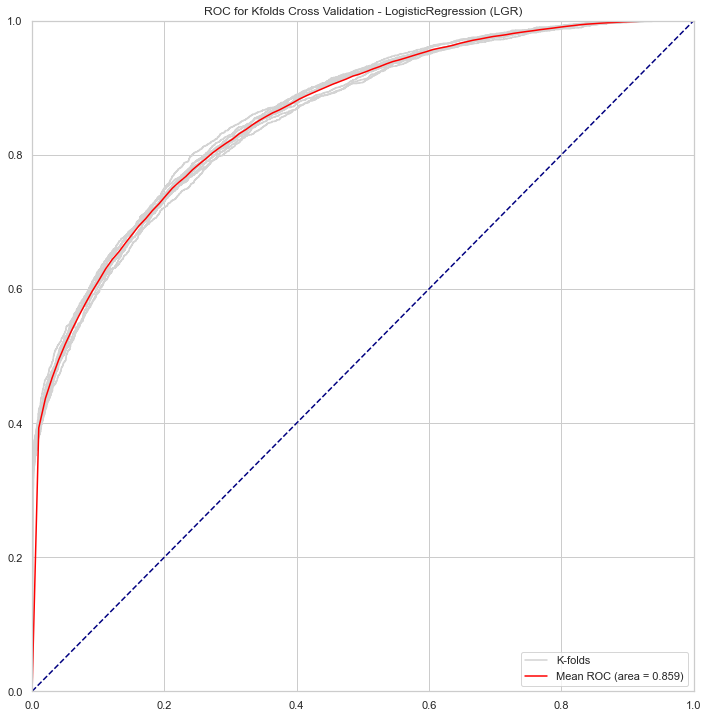

 25%|██▌       | 1/4 [00:02<00:06,  2.04s/it]

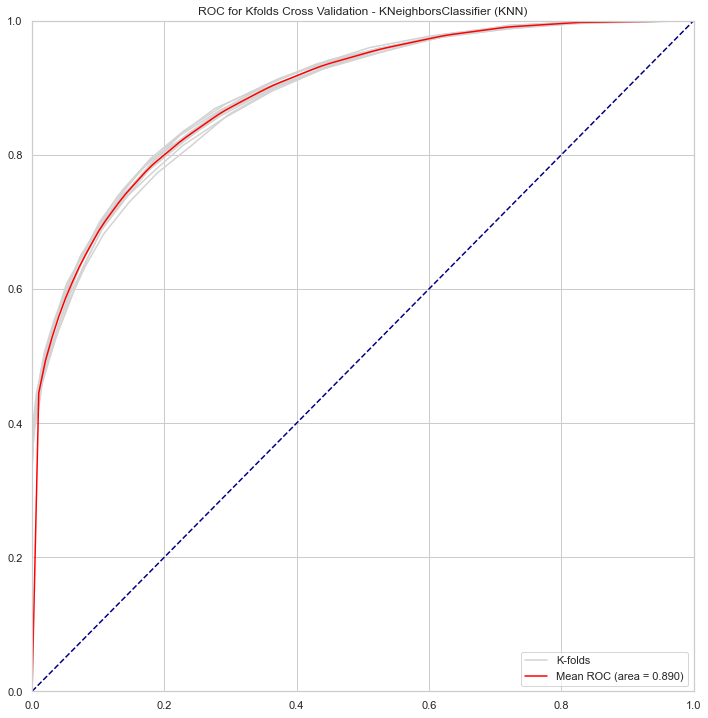

 50%|█████     | 2/4 [04:05<04:48, 144.07s/it]

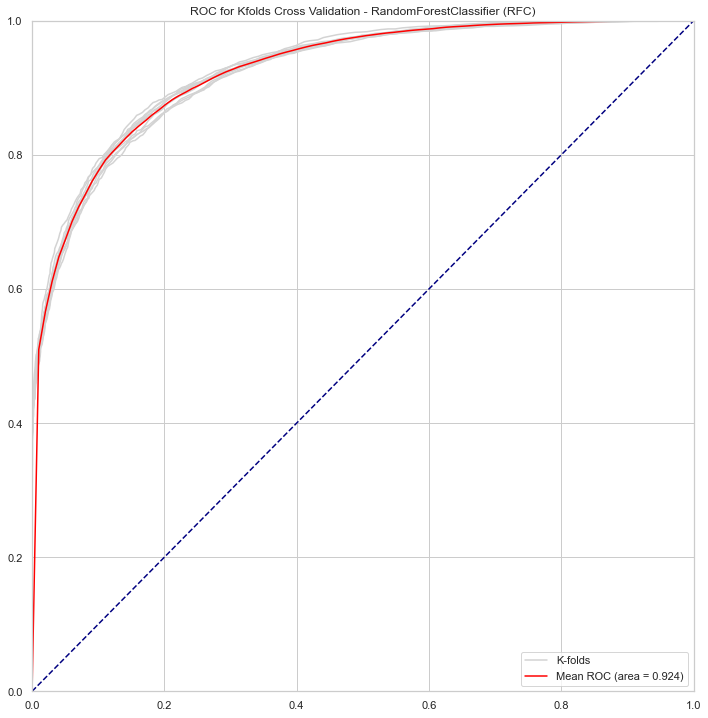

 75%|███████▌  | 3/4 [06:46<02:31, 151.91s/it]

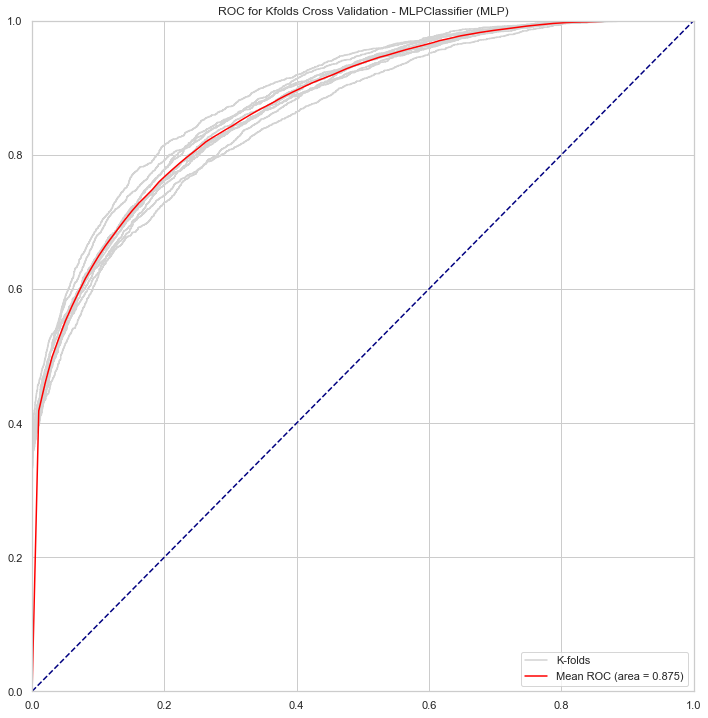

100%|██████████| 4/4 [30:24<00:00, 456.02s/it]


In [86]:
# Plot roc curves for every classifier 
for name, clf in tqdm(classifiers_ROC):
    full_name = type(clf[name]).__name__
    KfoldPlot(df_for_cv, y_cv, clf, k=10)
    plt.tight_layout()
    plt.title('ROC for Kfolds Cross Validation - {} ({})'.format(full_name, name))
    plt.show()

### Confusion Matrices for all Models

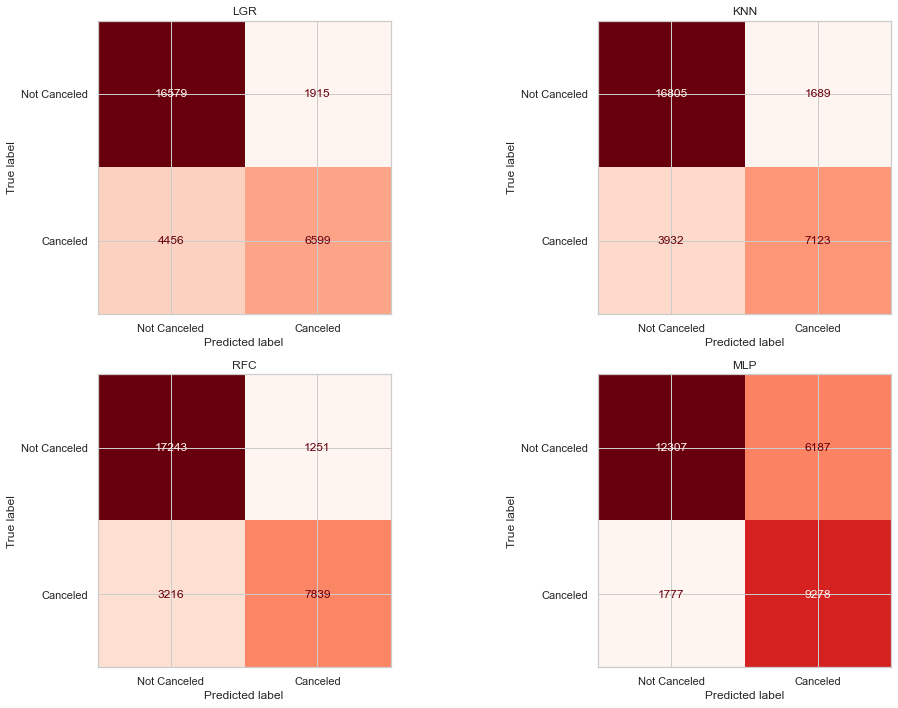

In [87]:
si = np.ceil(len(classifiers_opt)+1)
nrows = int(si/2)
              
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15,10))

for clf, ax in zip(classifiers_opt, axes.flatten()):
    plot_confusion_matrix(clf[1], 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Reds',
                          colorbar=False, 
                          display_labels=['Not Canceled', 'Canceled'])
    ax.title.set_text(clf[0])
if (len(classifiers_opt)) % 2 != 0:
    fig.delaxes(axes[nrows-1, 1])
plt.tight_layout()  
plt.show()

### AUC Score

And lastly, AUC score for each model tested on validation set

In [88]:
for name, clf in tqdm(classifiers_opt):
    full_name = type(clf[name]).__name__
    score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print("The AUC Score for the {} ({}) model is: {} \t\t".format(full_name, name, score))

  0%|          | 0/4 [00:00<?, ?it/s]

The AUC Score for the LogisticRegression (LGR) model is: 0.8401366790906603 		


 50%|█████     | 2/4 [00:25<00:25, 12.50s/it]

The AUC Score for the KNeighborsClassifier (KNN) model is: 0.8758072428736896 		


100%|██████████| 4/4 [00:25<00:00,  6.39s/it]

The AUC Score for the RandomForestClassifier (RFC) model is: 0.9222913666867253 		
The AUC Score for the MLPClassifier (MLP) model is: 0.8497657973784156 		


A full classification report to the model of choice:

In [89]:
RFC = classifiers_opt[2][1]

In [90]:
preds_test = RFC.predict(X_test)
print(type(RFC[0]).__name__, "Test Data", classification_report(y_test, preds_test))

RandomForestClassifier Test Data               precision    recall  f1-score   support

           0       0.84      0.93      0.89     18494
           1       0.86      0.71      0.78     11055

    accuracy                           0.85     29549
   macro avg       0.85      0.82      0.83     29549
weighted avg       0.85      0.85      0.85     29549



# Part 5: Predictions for Submission Data <a class="anchor" id="part5"></a>

As a final step, we would load and process the test data as needed to predict cancellation

## Applying Features Engineering Functions to Data Test

Our classifier of choice will be the trained and hyper-tuned RFC model from before, now we would define the pipeline for preprocessing the submission data

In [101]:
sub_pipe = Pipeline([
    ('pre', process_pipe),
    ('clf', RFC)
#     classifiers[0]
])

def postprocessor(arr, test):
    df = pd.DataFrame(arr)
    df['cancel_proba'] = df.iloc[:,1]
    df['Unnamed: 0'] = test['Unnamed: 0']
    df = df[['Unnamed: 0', 'cancel_proba']]
    return df

Loading the submission data

In [102]:
test = pd.read_csv('Data/feature_data_test.csv')

Before we begin let's just have a look on the "missing values" status of the submission data:

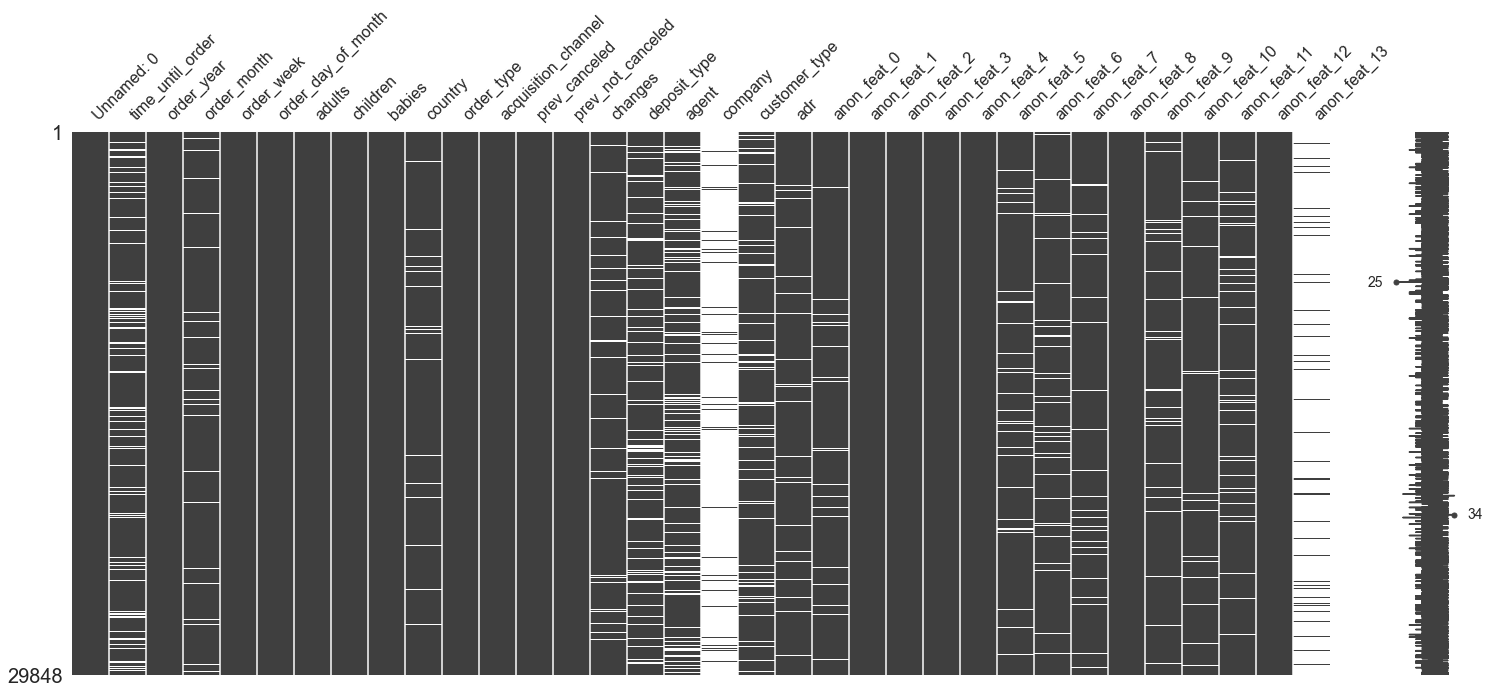

In [103]:
msno.matrix(test)
plt.show()

It's clear that the missing values behave quite similar to those of the training values, therefore it will be handled automatically inside the preprocessor pipe.

In [104]:
arr = sub_pipe.predict_proba(test)
sub = postprocessor(arr, test)

In [105]:
sub.set_index('Unnamed: 0', inplace=True)
sub.index.name = None

In [106]:
sub.head(10)

,cancel_proba
22167,0.05
11664,1.00
43471,0.45
7697,0.65
106026,0.70
31230,0.09
116309,0.24
83603,0.70
38259,0.75
26880,0.54


In [107]:
sub.to_csv('subbmission_group_7.csv')